<a href="https://colab.research.google.com/github/Arabasma/ML-and-NLP-Projects/blob/main/TP_App_Non_Supervis%C3%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation de package

In [ ]:
!pip install scikit-learn-extra

     |████████████████████████████████| 1.7 MB 7.9 MB/s 


In [ ]:
!pip install umap.learn

     |████████████████████████████████| 86 kB 2.9 MB/s 
     |████████████████████████████████| 1.1 MB 16.5 MB/s 
  Created wheel for umap.learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=415f63be8f11595b731f8642fbff32868a8ba889448d5b7a559565f05f4be557
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=507fb0808d33fa55584596102d06b5debf018d87322bc6ddf1f2b2810f4a4a87
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap.learn pynndescent


In [ ]:
import pandas as pd
import numpy as np
import warnings
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering

import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment
from sklearn_extra.cluster import KMedoids

# Définition des fonctions

In [ ]:
#Définir une fonction pour calculer correctement l'accuracy

def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)


def accuracy(true_row_labels, predicted_row_labels):
    """Get the best accuracy.

    Parameters
    ----------
    true_row_labels: array-like
        The true row labels, given as external information
    predicted_row_labels: array-like
        The row labels predicted by the model

    Returns
    -------
    float
        Best value of accuracy
    """

    cm = confusion_matrix(true_row_labels, predicted_row_labels)
    indexes = linear_sum_assignment(_make_cost_m(cm))
    total = 0
    for row, column in zip(*indexes):
        value = cm[row][column]
        total += value

    return (total * 1. / np.sum(cm))

In [ ]:
#fonction pour dessiner les graphes
def eval_clustering_7(X_reduced, labels, model1, model2, model3, model4, model5, model6, model7, title0, title1, title2, title3, title4,
                      title5, title6,title7):

    colors = ['gold','turquoise','lightgreen','crimson']
    plt.subplots(1,4,figsize=(20,8))

    plt.subplot(1, 4, 1)
    plt.scatter(X_reduced[:,0], X_reduced[:,1] , c=labels, cmap=matplotlib.colors.ListedColormap(colors))
    plt.title(title0)

    plt.subplot(1, 4, 2)
    plt.scatter(X_reduced[:,0], X_reduced[:,1] , c=model1["labels"], cmap=matplotlib.colors.ListedColormap(colors))
    plt.title(title1 +"\n NMI "+str(model1["NMI"])+"\n ARI "+str(model1["ARI"])+"\n accuracy "+str(model1["accuracy"]))

    plt.subplot(1, 4, 3)
    plt.scatter(X_reduced[:,0], X_reduced[:,1] , c=model2["labels"], cmap=matplotlib.colors.ListedColormap(colors))
    plt.title(title2+ "\n NMI "+str(model2["NMI"])+"\n ARI "+str(model2["ARI"])+"\n accuracy "+str(model2["accuracy"]))

    plt.subplot(1, 4, 4)
    plt.scatter(X_reduced[:,0], X_reduced[:,1] , c=model3["labels"], cmap=matplotlib.colors.ListedColormap(colors))
    plt.title(title3+"\n NMI "+str(model3["NMI"])+"\n ARI "+str(model3["ARI"])+"\n accuracy "+str(model3["accuracy"]))

    plt.subplots(1,4,figsize=(20,8))

    plt.subplot(1, 4, 1)
    plt.scatter(X_reduced[:,0], X_reduced[:,1] , c=model4["labels"], cmap=matplotlib.colors.ListedColormap(colors))
    plt.title(title4 +"\n NMI "+str(model4["NMI"])+"\n ARI "+str(model4["ARI"])+"\n accuracy "+str(model4["accuracy"]))

    plt.subplot(1, 4, 2)
    plt.scatter(X_reduced[:,0], X_reduced[:,1] , c=model5["labels"], cmap=matplotlib.colors.ListedColormap(colors))
    plt.title(title5 +"\n NMI "+str(model5["NMI"])+"\n ARI "+str(model5["ARI"])+"\n accuracy "+str(model5["accuracy"]))

    plt.subplot(1, 4, 3)
    plt.scatter(X_reduced[:,0], X_reduced[:,1] , c=model6["labels"], cmap=matplotlib.colors.ListedColormap(colors))
    plt.title(title6+ "\n NMI "+str(model6["NMI"])+"\n ARI "+str(model6["ARI"])+"\n accuracy "+str(model6["accuracy"]))

    plt.subplot(1, 4, 4)
    plt.scatter(X_reduced[:,0], X_reduced[:,1] , c=model7["labels"], cmap=matplotlib.colors.ListedColormap(colors))
    plt.title(title7+"\n NMI "+str(model7["NMI"])+"\n ARI "+str(model7["ARI"])+"\n accuracy "+str(model7["accuracy"]))

In [ ]:
#Définir un autoencodeur
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super().__init__()
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.embedding_dim)
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(self.embedding_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.input_dim),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
def autoencoder(X, embedding_dim, n_epochs=50, batch_size=64, learning_rate=1e-3, weight_decay=1e-8, seed=None, return_model=False):
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    if seed is not None:
      torch.manual_seed(seed)
    dataloader = DataLoader(dataset=X, batch_size=batch_size, shuffle=True)
    model = AutoEncoder(input_dim=X.shape[1], embedding_dim=embedding_dim)

    if device == 'cuda':
      model.cuda()

    loss_function = torch.nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(),
                                lr=learning_rate,
                                weight_decay=weight_decay)

    losses = []

    model.train()
    for epoch in tqdm(range(n_epochs)):
        for batch in dataloader:
          batch = batch.to(device)
          reconstructed = model(batch)

          loss = loss_function(reconstructed, batch)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          losses.append(loss)

    model.eval()
    tensor_X = torch.tensor(X)
    tensor_X = tensor_X.to(device)
    encoded_X = model.encoder(tensor_X)
    encoded_X = encoded_X.detach().cpu().numpy()

    if return_model:
      return encoded_X, model, losses
    else:
      return encoded_X

# Approche 1 : concaténer les données

## Importation des données

In [ ]:
! unzip data.zip

In [ ]:
#Importation des tableaux de l'accéleration estimée sur x,y,z
df_acce_x = pd.read_csv('acce_x.txt', sep=" ", header= None)
df_acce_y = pd.read_csv('acce_y.txt', sep=" ", header= None)
df_acce_z = pd.read_csv('acce_z.txt', sep=" ", header= None)

In [ ]:
#Importation des tableaux de l'accéleration mesurée sur x,y,z
df_accm_x = pd.read_csv('accm_x.txt', sep=" ", header= None)
df_accm_y = pd.read_csv('accm_y.txt', sep=" ", header= None)
df_accm_z = pd.read_csv('accm_z.txt', sep=" ", header= None)

In [ ]:
#Importation des tableaux de la vitesse sur x,y,z
df_vit_x = pd.read_csv('vit_x.txt', sep=" ", header= None)
df_vit_y = pd.read_csv('vit_y.txt', sep=" ", header= None)
df_vit_z = pd.read_csv('vit_z.txt', sep=" ", header= None)

In [ ]:
#Importation du tableau de label
df_lab = pd.read_csv('lab.txt', sep=" ", header= None)
#Convertir df_lab to numpay array
labels_int = df_lab[0].to_numpy()

In [ ]:
frames= [df_acce_x, df_acce_y, df_acce_z, df_accm_x, df_accm_y, df_accm_z, df_vit_x, df_vit_y, df_vit_z]

In [ ]:
df=pd.concat(frames, axis=1)

In [ ]:
#nombre de classes
k= 6

In [ ]:
X = df.to_numpy()

In [ ]:
 df.shape

(347, 1152)

## Clustering sur les données originales

### k-means

In [ ]:
#Kmeans
kmeans_pred_labels=KMeans(k, random_state=0).fit(df).labels_
kmeans={"labels": kmeans_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmeans_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmeans_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmeans_pred_labels, labels_int),2)}

### Clustering Spectral

In [ ]:
#Spectral clustering
sepectral_pred_labels=SpectralClustering(k, affinity='nearest_neighbors', n_neighbors=5, random_state=0).fit(df).labels_

spectral_clustering= {"labels": sepectral_pred_labels,
                      "NMI": round(normalized_mutual_info_score(sepectral_pred_labels, labels_int),2),
                      "ARI": round(adjusted_rand_score(sepectral_pred_labels, labels_int)),
                      "accuracy": round(accuracy(sepectral_pred_labels, labels_int),2)}


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


### k-medoids with PAM

In [ ]:
kmedoids_pred_labels = KMedoids(n_clusters=k,method='pam', random_state=0).fit(df).fit(df).labels_
kmedoids={"labels": kmedoids_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmedoids_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmedoids_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmedoids_pred_labels, labels_int),2)}

### CAH

In [ ]:
#CAH with ward aggregation criteria
cah_ward_pred_labels=AgglomerativeClustering(k, linkage = 'ward').fit(df).labels_

cah_ward= {"labels": cah_ward_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_ward_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_ward_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_ward_pred_labels, labels_int),2)}

In [ ]:
#CAH with complete aggregation criteria
cah_complete_pred_labels=AgglomerativeClustering(k, linkage = 'complete').fit(df).labels_

cah_complete= {"labels": cah_complete_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_complete_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_complete_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_complete_pred_labels, labels_int),2)}

In [ ]:
#CAH with average aggregation criteria
cah_average_pred_labels=AgglomerativeClustering(k, linkage = 'average').fit(df).labels_

cah_average= {"labels": cah_average_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_average_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_average_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_average_pred_labels, labels_int),2)}

In [ ]:
#CAH with single aggregation criteria
cah_single_pred_labels=AgglomerativeClustering(k, linkage = 'single').fit(df).labels_

cah_single= {"labels": cah_single_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_single_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_single_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_single_pred_labels, labels_int),2)}

In [ ]:
#PCA for visualisation
X_reduced=PCA(n_components=2, whiten=False, random_state=42).fit_transform(df)

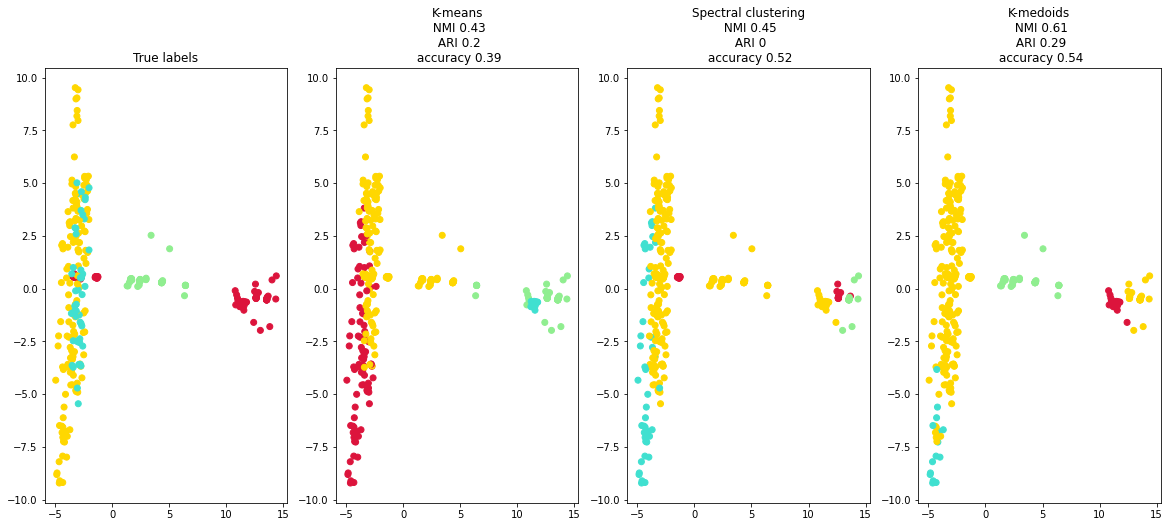

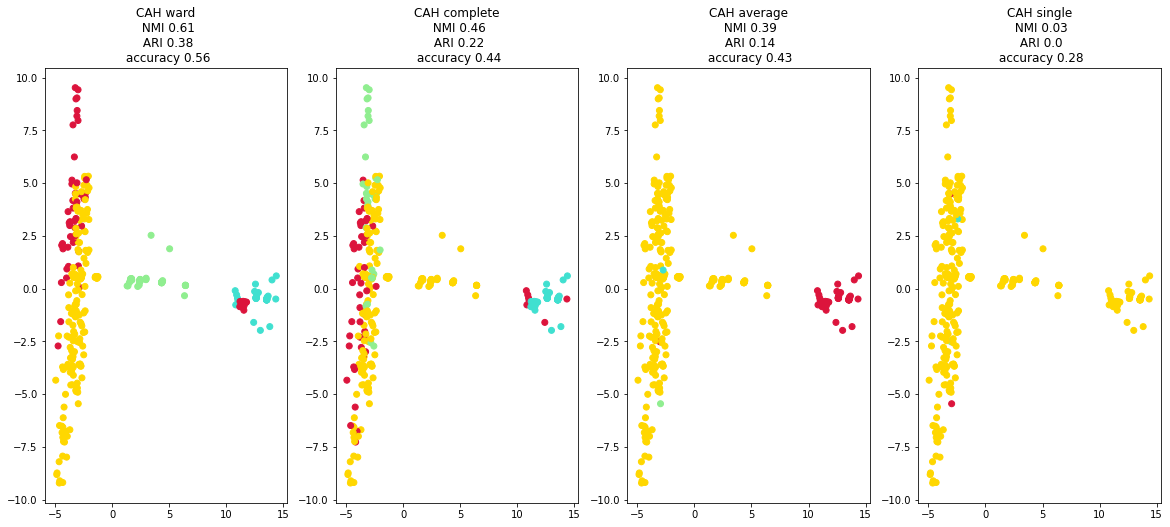

In [ ]:
eval_clustering_7(X_reduced, labels_int ,kmeans, spectral_clustering, kmedoids, cah_ward, cah_complete, cah_average,
                  cah_single, "True labels", "K-means", "Spectral clustering", "K-medoids", "CAH ward", "CAH complete",
                  "CAH average", "CAH single")

### SOM

In [ ]:
!pip install rpy2

In [ ]:
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

In [ ]:
from rpy2.robjects.packages import importr
utils= importr('utils')

In [ ]:
utils.install_packages('FCPS', repos="https://cloud.r-project.org")

In [ ]:
fcps=importr('FCPS')

In [ ]:
utils.install_packages('kohonen')

In [ ]:
som=fcps.SOMclustering(X, ClusterNo=k, alpha=0.5)

In [ ]:
pred_labels= som[0]

In [ ]:
normalized_mutual_info_score(labels_int, pred_labels)

0.5957781414094304

In [ ]:
adjusted_rand_score(pred_labels, labels_int)

0.40614998867187435

In [ ]:
accuracy(pred_labels, labels_int)

0.5706051873198847

## Clustering sur les données réduites

### Réduction de dimension des données

In [ ]:
#PCA
X_reduced_PCA =PCA(n_components=2, whiten=False, random_state=42).fit_transform(df)
#t-SNE
X_reduced_TSNE =TSNE(n_components=2, random_state=42).fit_transform(df)
#UMAP
X_reduced_UMAP =UMAP(n_components=2, random_state=42).fit_transform(df)
#Authoencoder
X_reduced_autoencoder = autoencoder(X.astype("float32"), 2, seed=42)



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
100%|██████████| 50/50 [00:02<00:00, 22.64it/s]


### ACP

In [ ]:
#Kmeans
kmeans_pred_labels=KMeans(k, random_state=42).fit(X_reduced_PCA).labels_
kmeans={"labels": kmeans_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmeans_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmeans_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmeans_pred_labels, labels_int),2)}

In [ ]:
#Spectral clustering
sepectral_pred_labels=SpectralClustering(k, affinity='nearest_neighbors', n_neighbors=10, random_state=42).fit(X_reduced_PCA).labels_

spectral_clustering= {"labels": sepectral_pred_labels,
                      "NMI": round(normalized_mutual_info_score(sepectral_pred_labels, labels_int),2),
                      "ARI": round(adjusted_rand_score(sepectral_pred_labels, labels_int),2),
                      "accuracy": round(accuracy(sepectral_pred_labels, labels_int),2)}

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


In [ ]:
#kmedois
kmedoids_pred_labels = KMedoids(n_clusters=k,method='pam', random_state=42).fit(X_reduced_PCA).labels_
kmedoids={"labels": kmedoids_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmedoids_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmedoids_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmedoids_pred_labels, labels_int),2)}

In [ ]:
#CAH with ward aggregation criteria
cah_ward_pred_labels=AgglomerativeClustering(k, linkage = 'ward').fit(X_reduced_PCA).labels_

cah_ward= {"labels": cah_ward_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_ward_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_ward_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_ward_pred_labels, labels_int),2)}

In [ ]:
#CAH with complete aggregation criteria
cah_complete_pred_labels=AgglomerativeClustering(k, linkage = 'complete').fit(X_reduced_PCA).labels_

cah_complete= {"labels": cah_complete_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_complete_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_complete_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_complete_pred_labels, labels_int),2)}

In [ ]:
#CAH with average aggregation criteria
cah_average_pred_labels=AgglomerativeClustering(k, linkage = 'average').fit(X_reduced_PCA).labels_

cah_average= {"labels": cah_average_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_average_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_average_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_average_pred_labels, labels_int),2)}

In [ ]:
#CAH with single aggregation criteria
cah_single_pred_labels=AgglomerativeClustering(k, linkage = 'single').fit(X_reduced_PCA).labels_

cah_single= {"labels": cah_single_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_single_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_single_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_single_pred_labels, labels_int),2)}

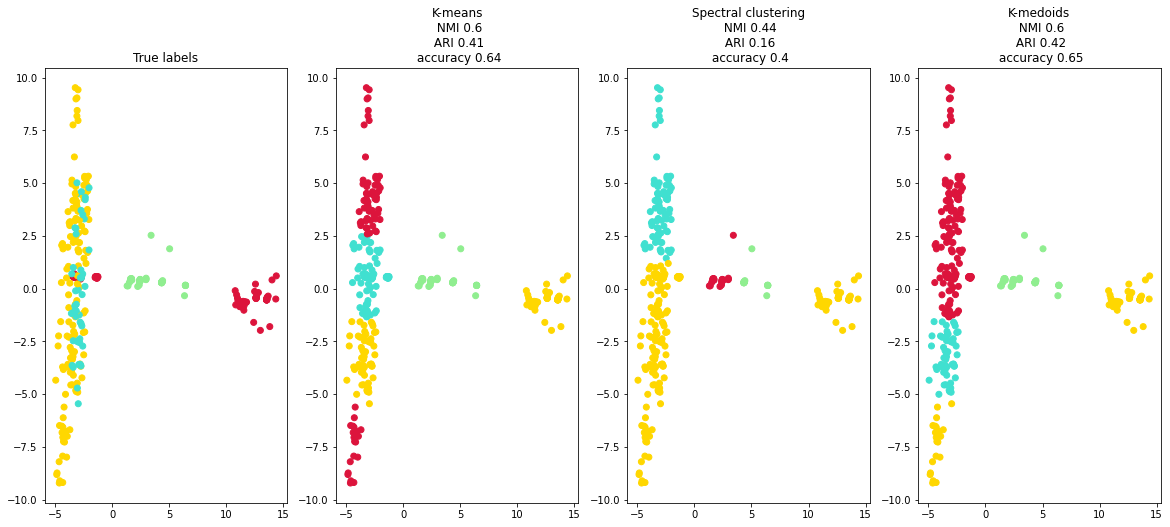

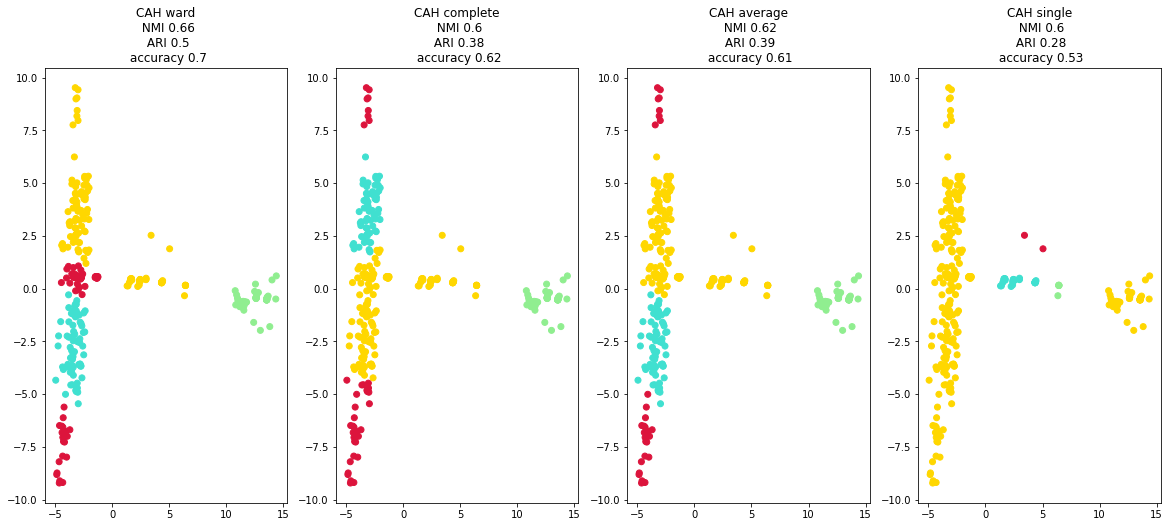

In [ ]:
eval_clustering_7(X_reduced_PCA, labels_int ,kmeans, spectral_clustering, kmedoids, cah_ward, cah_complete, cah_average,
                  cah_single, "True labels", "K-means", "Spectral clustering", "K-medoids", "CAH ward", "CAH complete",
                  "CAH average", "CAH single")

### t-SNE

In [ ]:
#Kmeans
kmeans_pred_labels=KMeans(k, random_state=42).fit(X_reduced_TSNE).labels_
kmeans={"labels": kmeans_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmeans_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmeans_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmeans_pred_labels, labels_int),2)}

In [ ]:
#Spectral clustering
sepectral_pred_labels=SpectralClustering(k, affinity='nearest_neighbors', n_neighbors=10, random_state=42).fit(X_reduced_TSNE).labels_

spectral_clustering= {"labels": sepectral_pred_labels,
                      "NMI": round(normalized_mutual_info_score(sepectral_pred_labels, labels_int),2),
                      "ARI": round(adjusted_rand_score(sepectral_pred_labels, labels_int),2),
                      "accuracy": round(accuracy(sepectral_pred_labels, labels_int),2)}

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


In [ ]:
#HDBSCAN
hdbscan_pred_labels=hdbscan.HDBSCAN(algorithm='best', alpha=1.0, leaf_size=40, cluster_selection_method='eom', metric='euclidean').fit(X_reduced_TSNE).labels_

hdbscan_= {"labels": hdbscan_pred_labels,
          "NMI": round(normalized_mutual_info_score(hdbscan_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(hdbscan_pred_labels, labels_int),2),
          "accuracy": round(accuracy(hdbscan_pred_labels, labels_int),2)}

In [ ]:
#kmedois
kmedoids_pred_labels = KMedoids(n_clusters=k,method='pam', random_state=42).fit(X_reduced_TSNE).labels_
kmedoids={"labels": kmedoids_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmedoids_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmedoids_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmedoids_pred_labels, labels_int),2)}

In [ ]:
#CAH with ward aggregation criteria
cah_ward_pred_labels=AgglomerativeClustering(k, linkage = 'ward').fit(X_reduced_TSNE).labels_

cah_ward= {"labels": cah_ward_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_ward_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_ward_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_ward_pred_labels, labels_int),2)}

In [ ]:
#CAH with complete aggregation criteria
cah_complete_pred_labels=AgglomerativeClustering(k, linkage = 'complete').fit(X_reduced_TSNE).labels_

cah_complete= {"labels": cah_complete_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_complete_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_complete_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_complete_pred_labels, labels_int),2)}

In [ ]:
#CAH with average aggregation criteria
cah_average_pred_labels=AgglomerativeClustering(k, linkage = 'average').fit(X_reduced_TSNE).labels_

cah_average= {"labels": cah_average_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_average_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_average_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_average_pred_labels, labels_int),2)}

In [ ]:
#CAH with single aggregation criteria
cah_single_pred_labels=AgglomerativeClustering(k, linkage = 'single').fit(X_reduced_TSNE).labels_

cah_single= {"labels": cah_single_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_single_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_single_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_single_pred_labels, labels_int),2)}

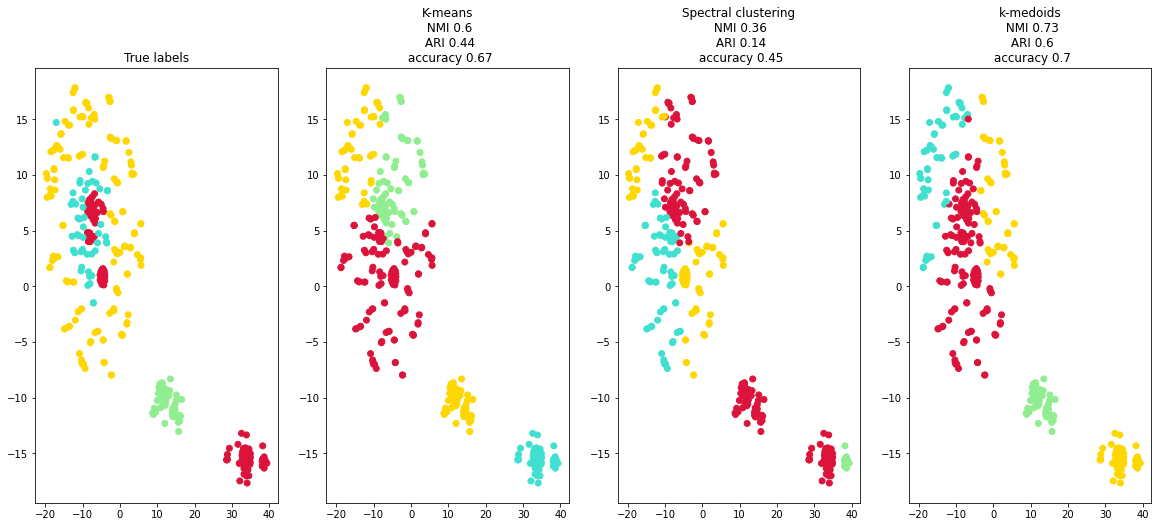

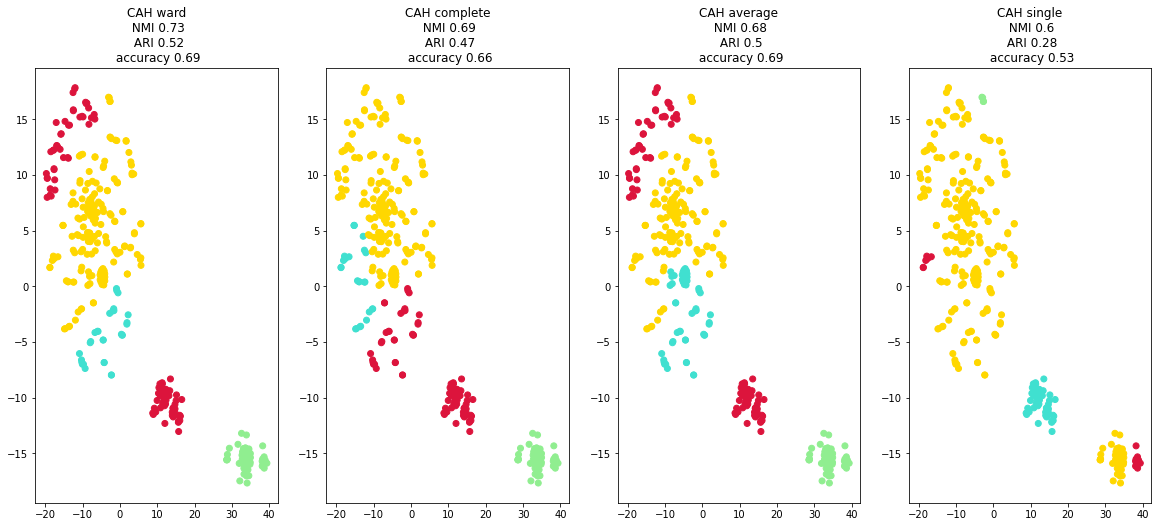

In [ ]:
eval_clustering_7(X_reduced_TSNE, labels_int ,kmeans, spectral_clustering, kmedoids, cah_ward, cah_complete, cah_average,
                  cah_single, "True labels", "K-means", "Spectral clustering", "k-medoids", "CAH ward", "CAH complete",
                  "CAH average", "CAH single")

### UMAP

In [ ]:
#Kmeans
kmeans_pred_labels=KMeans(k, random_state=42).fit(X_reduced_UMAP).labels_
kmeans={"labels": kmeans_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmeans_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmeans_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmeans_pred_labels, labels_int),2)}

In [ ]:
#Spectral clustering
sepectral_pred_labels=SpectralClustering(k, affinity='nearest_neighbors', n_neighbors=10, random_state=42).fit(X_reduced_UMAP).labels_

spectral_clustering= {"labels": sepectral_pred_labels,
                      "NMI": round(normalized_mutual_info_score(sepectral_pred_labels, labels_int),2),
                      "ARI": round(adjusted_rand_score(sepectral_pred_labels, labels_int),2),
                      "accuracy": round(accuracy(sepectral_pred_labels, labels_int),2)}

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


In [ ]:
#kmedois
kmedoids_pred_labels = KMedoids(n_clusters=k,method='pam', random_state=42).fit(X_reduced_UMAP).labels_
kmedoids={"labels": kmedoids_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmedoids_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmedoids_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmedoids_pred_labels, labels_int),2)}

In [ ]:
#HDBSCAN
hdbscan_pred_labels=hdbscan.HDBSCAN(algorithm='best', alpha=1.0, leaf_size=40, cluster_selection_method='eom', metric='euclidean').fit(X_reduced_UMAP).labels_

hdbscan_= {"labels": hdbscan_pred_labels,
          "NMI": round(normalized_mutual_info_score(hdbscan_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(hdbscan_pred_labels, labels_int),2),
          "accuracy": round(accuracy(hdbscan_pred_labels, labels_int),2)}

In [ ]:
#CAH with ward aggregation criteria
cah_ward_pred_labels=AgglomerativeClustering(k, linkage = 'ward').fit(X_reduced_UMAP).labels_

cah_ward= {"labels": cah_ward_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_ward_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_ward_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_ward_pred_labels, labels_int),2)}

In [ ]:
#CAH with complete aggregation criteria
cah_complete_pred_labels=AgglomerativeClustering(k, linkage = 'complete').fit(X_reduced_UMAP).labels_

cah_complete= {"labels": cah_complete_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_complete_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_complete_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_complete_pred_labels, labels_int),2)}

In [ ]:
#CAH with average aggregation criteria
cah_average_pred_labels=AgglomerativeClustering(k, linkage = 'average').fit(X_reduced_UMAP).labels_

cah_average= {"labels": cah_average_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_average_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_average_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_average_pred_labels, labels_int),2)}

In [ ]:
#CAH with single aggregation criteria
cah_single_pred_labels=AgglomerativeClustering(k, linkage = 'single').fit(X_reduced_UMAP).labels_

cah_single= {"labels": cah_single_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_single_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_single_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_single_pred_labels, labels_int),2)}

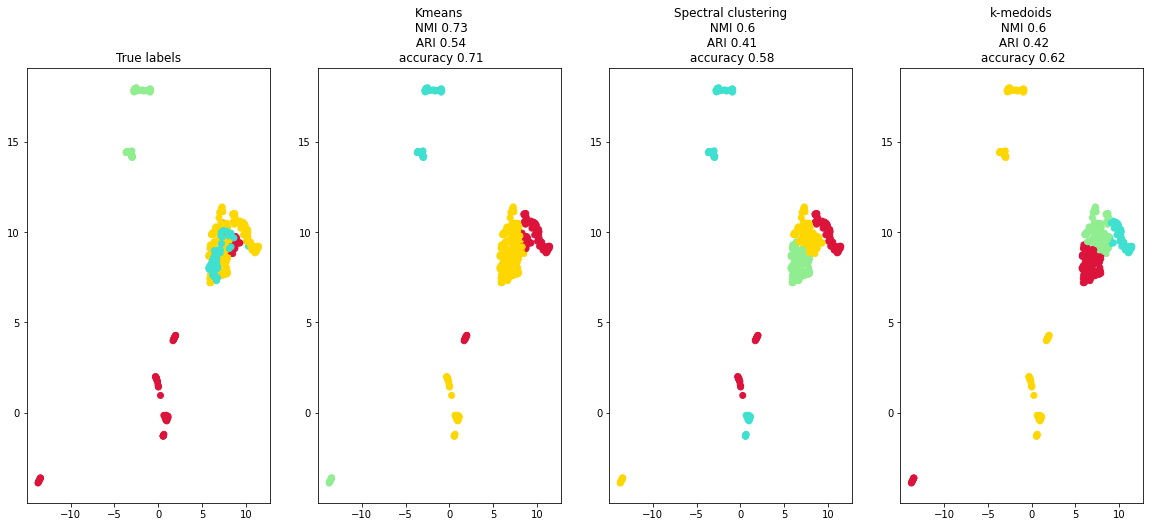

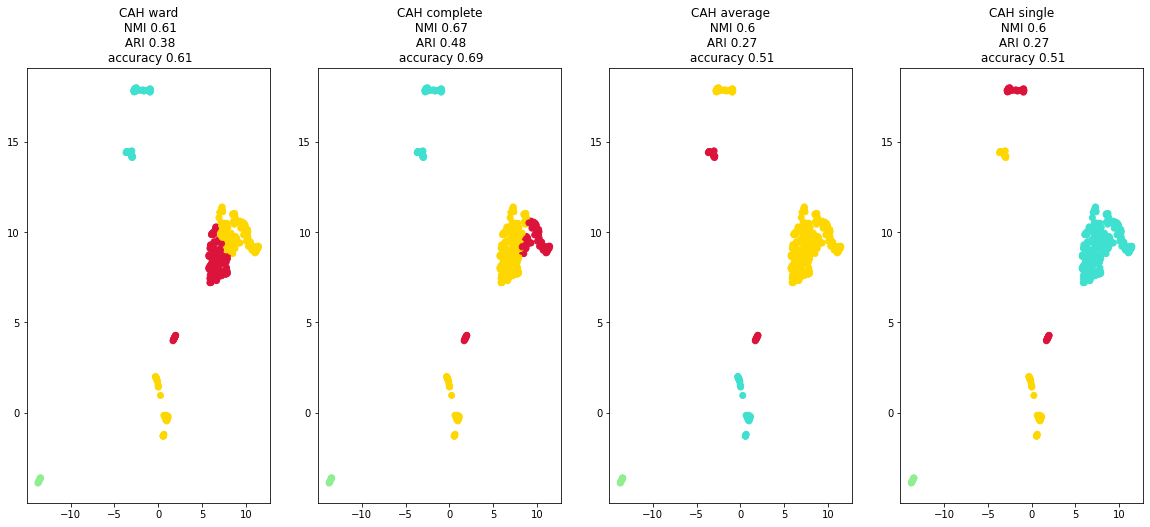

In [ ]:
eval_clustering_7(X_reduced_UMAP, labels_int ,kmeans, spectral_clustering, kmedoids, cah_ward, cah_complete, cah_average,
                  cah_single, "True labels", "Kmeans", "Spectral clustering", "k-medoids", "CAH ward", "CAH complete",
                  "CAH average", "CAH single")

### Autoencodeur

In [ ]:
#Kmeans
kmeans_pred_labels=KMeans(k, random_state=42).fit(X_reduced_autoencoder).labels_
kmeans={"labels": kmeans_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmeans_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmeans_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmeans_pred_labels, labels_int),2)}

In [ ]:
#Spectral clustering
sepectral_pred_labels=SpectralClustering(k, affinity='nearest_neighbors', n_neighbors=10, random_state=42).fit(X_reduced_autoencoder).labels_

spectral_clustering= {"labels": sepectral_pred_labels,
                      "NMI": round(normalized_mutual_info_score(sepectral_pred_labels, labels_int),2),
                      "ARI": round(adjusted_rand_score(sepectral_pred_labels, labels_int),2),
                      "accuracy": round(accuracy(sepectral_pred_labels, labels_int),2)}

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


In [ ]:
#kmedois
kmedoids_pred_labels = KMedoids(n_clusters=k,method='pam', random_state=42).fit(X_reduced_autoencoder).labels_
kmedoids={"labels": kmedoids_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmedoids_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmedoids_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmedoids_pred_labels, labels_int),2)}

In [ ]:
#HDBSCAN
hdbscan_pred_labels=hdbscan.HDBSCAN(algorithm='best', alpha=1.0, leaf_size=40, cluster_selection_method='eom', metric='euclidean').fit(X_reduced_autoencoder).labels_

hdbscan_= {"labels": hdbscan_pred_labels,
          "NMI": round(normalized_mutual_info_score(hdbscan_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(hdbscan_pred_labels, labels_int),2),
          "accuracy": round(accuracy(hdbscan_pred_labels, labels_int),2)}

In [ ]:
#CAH with ward aggregation criteria
cah_ward_pred_labels=AgglomerativeClustering(k, linkage = 'ward').fit(X_reduced_autoencoder).labels_

cah_ward= {"labels": cah_ward_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_ward_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_ward_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_ward_pred_labels, labels_int),2)}

In [ ]:
#CAH with complete aggregation criteria
cah_complete_pred_labels=AgglomerativeClustering(k, linkage = 'complete').fit(X_reduced_autoencoder).labels_

cah_complete= {"labels": cah_complete_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_complete_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_complete_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_complete_pred_labels, labels_int),2)}

In [ ]:
#CAH with average aggregation criteria
cah_average_pred_labels=AgglomerativeClustering(k, linkage = 'average').fit(X_reduced_autoencoder).labels_

cah_average= {"labels": cah_average_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_average_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_average_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_average_pred_labels, labels_int),2)}

In [ ]:
#CAH with single aggregation criteria
cah_single_pred_labels=AgglomerativeClustering(k, linkage = 'single').fit(X_reduced_autoencoder).labels_

cah_single= {"labels": cah_single_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_single_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_single_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_single_pred_labels, labels_int),2)}

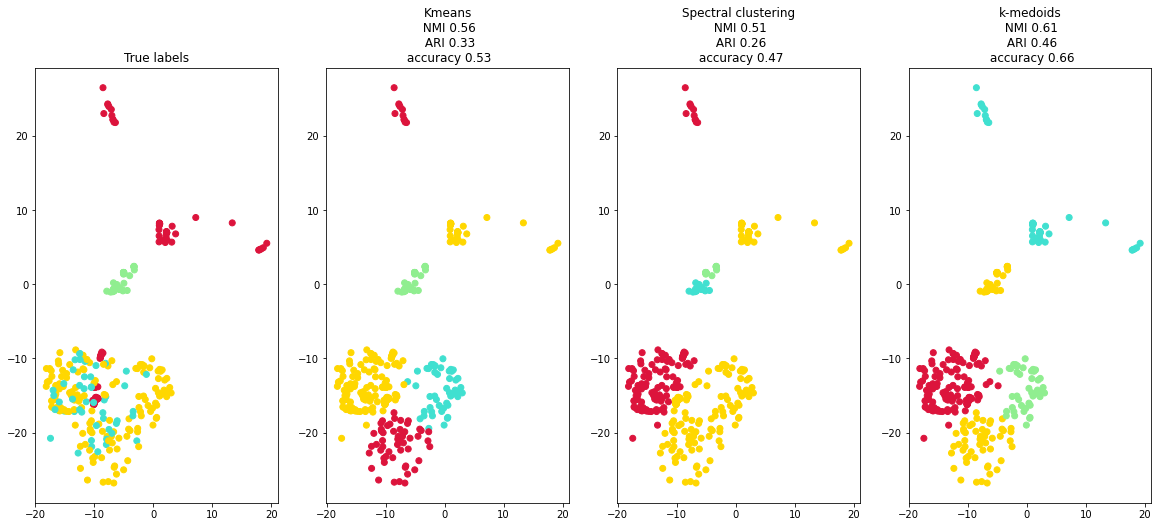

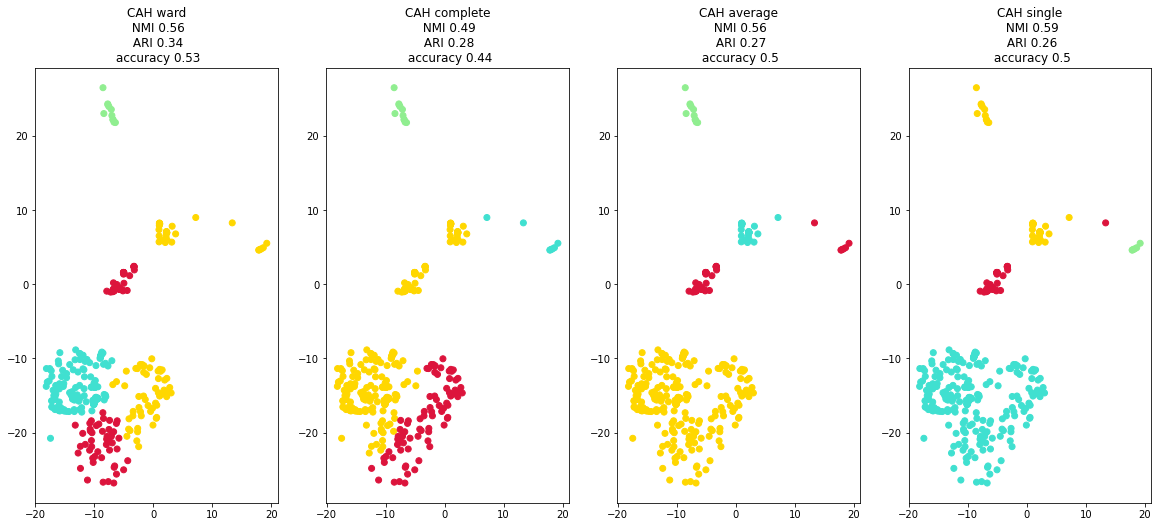

In [ ]:
eval_clustering_7(X_reduced_autoencoder, labels_int ,kmeans, spectral_clustering, kmedoids, cah_ward, cah_complete, cah_average,
                  cah_single, "True labels", "Kmeans", "Spectral clustering", "k-medoids", "CAH ward", "CAH complete",
                  "CAH average", "CAH single")

##Times series clustering

In [ ]:
!pip install tslearn

In [ ]:
from tslearn.clustering import TimeSeriesKMeans

In [ ]:
#K-means sur séries temporelles avec la métric euclidienne
km_euclidian = TimeSeriesKMeans(n_clusters=6, max_iter=5,  metric="euclidean", random_state=0).fit(df)

In [ ]:
kmeans_pred_labels = km_euclidian.labels_

In [ ]:
print(round(normalized_mutual_info_score(kmeans_pred_labels, labels_int),2))

0.48


In [ ]:
print(round(adjusted_rand_score(kmeans_pred_labels, labels_int),2))

0.28


In [ ]:
print(round(accuracy(kmeans_pred_labels, labels_int),2))

0.46


In [ ]:
#K-means sur séries temporelles avec la métric DTW
km = TimeSeriesKMeans(n_clusters=6, max_iter=5,  metric="dtw", random_state=0).fit(df)

In [ ]:
kmeans_pred_labels = km.labels_

In [ ]:
print(round(normalized_mutual_info_score(kmeans_pred_labels, labels_int),2))

0.79


In [ ]:
print(round(adjusted_rand_score(kmeans_pred_labels, labels_int),2))

0.74


In [ ]:
print(round(accuracy(kmeans_pred_labels, labels_int),2))

0.76


In [ ]:
#K-means sur séries temporelles avec la métric DBA DTW
dba_km = TimeSeriesKMeans(n_clusters=6, n_init=2, metric="dtw", verbose=True, max_iter_barycenter=10, random_state=0).fit(df)

In [ ]:
kmeans_pred_labels = dba_km.labels_

In [ ]:
print(round(normalized_mutual_info_score(kmeans_pred_labels, labels_int),2))



0.79


In [ ]:
print(round(adjusted_rand_score(kmeans_pred_labels, labels_int),2))

0.74


In [ ]:
print(round(accuracy(kmeans_pred_labels, labels_int),2))

0.76


In [ ]:
#K-means sur séries temporelles avec la métric soft DTW : elle prend beaucoup de temps à l'exécution de ce fait on a pas pu avoir les résultats
sdtw_km = TimeSeriesKMeans(n_clusters=6, metric="softdtw",max_iter=5, max_iter_barycenter=10,metric_params={"gamma": .01}, verbose=True, random_state=0).fit(df)

In [ ]:
kmeans_pred_labels = sdtw_km.labels_

In [ ]:
print(round(normalized_mutual_info_score(kmeans_pred_labels, labels_int),2))

In [ ]:
print(round(adjusted_rand_score(kmeans_pred_labels, labels_int),2))

In [ ]:
print(round(accuracy(kmeans_pred_labels, labels_int),2))

# Approche 2 : compresser les données avec la moyenne

## Importation des données

In [ ]:
! unzip data.zip

In [ ]:
#Importation des tableaux de l'accéleration estimée sur x,y,z
df_acce_x = pd.read_csv('acce_x.txt', sep=" ", header= None)
df_acce_y = pd.read_csv('acce_y.txt', sep=" ", header= None)
df_acce_z = pd.read_csv('acce_z.txt', sep=" ", header= None)

In [ ]:
#Importation des tableaux de l'accéleration mesurée sur x,y,z
df_accm_x = pd.read_csv('accm_x.txt', sep=" ", header= None)
df_accm_y = pd.read_csv('accm_y.txt', sep=" ", header= None)
df_accm_z = pd.read_csv('accm_z.txt', sep=" ", header= None)

In [ ]:
#Importation des tableaux de la vitesse sur x,y,z
df_vit_x = pd.read_csv('vit_x.txt', sep=" ", header= None)
df_vit_y = pd.read_csv('vit_y.txt', sep=" ", header= None)
df_vit_z = pd.read_csv('vit_z.txt', sep=" ", header= None)

In [ ]:
#Importation du tableau de label
df_lab = pd.read_csv('lab.txt', sep=" ", header= None)
#Convertir df_lab to numpay array
labels_int = df_lab[0].to_numpy()

In [ ]:
#definition du data frame qui aura en colonnes les 347 individus et en colonnes les 9 variables
#colonnes du dataframe
column_names = ["acce_x", "acce_y", "acce_z", "accm_x", "accm_y","accm_z","vit_x", "vit_y", "vit_z"]
df_data = pd.DataFrame(columns = column_names)

In [ ]:
#Remplir le dataframe avec la moyenne de chaque ligne pour chaque variable
df_data['acce_x'] = df_acce_x.mean(axis=1)
df_data['acce_y'] = df_acce_y.mean(axis=1)
df_data['acce_z'] = df_acce_z.mean(axis=1)
df_data['accm_x'] = df_accm_x.mean(axis=1)
df_data['accm_y'] = df_accm_y.mean(axis=1)
df_data['accm_z'] = df_accm_z.mean(axis=1)
df_data['vit_x'] = df_vit_x.mean(axis=1)
df_data['vit_y'] = df_vit_y.mean(axis=1)
df_data['vit_z'] = df_vit_z.mean(axis=1)

In [ ]:
#nombre de classes
k= 6

In [ ]:
X = df_data.to_numpy()

In [ ]:
 df_data.shape

(347, 9)

## Clustering sur les données originales

### k-means

In [ ]:
#Kmeans
kmeans_pred_labels=KMeans(k, random_state=42).fit(df_data).labels_
kmeans={"labels": kmeans_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmeans_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmeans_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmeans_pred_labels, labels_int),2)}

### Clustering Spectral

In [ ]:
#Spectral clustering
sepectral_pred_labels=SpectralClustering(k, affinity='nearest_neighbors', n_neighbors=5, random_state=42).fit(df_data).labels_

spectral_clustering= {"labels": sepectral_pred_labels,
                      "NMI": round(normalized_mutual_info_score(sepectral_pred_labels, labels_int),2),
                      "ARI": round(adjusted_rand_score(sepectral_pred_labels, labels_int)),
                      "accuracy": round(accuracy(sepectral_pred_labels, labels_int),2)}


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


### k-medoids with PAM

In [ ]:
kmedoids_pred_labels = KMedoids(n_clusters=k,method='pam', random_state=42).fit(df_data).fit(df_data).labels_
kmedoids={"labels": kmedoids_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmedoids_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmedoids_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmedoids_pred_labels, labels_int),2)}

### CAH

In [ ]:
#CAH with ward aggregation criteria
cah_ward_pred_labels=AgglomerativeClustering(k, linkage = 'ward').fit(df_data).labels_

cah_ward= {"labels": cah_ward_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_ward_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_ward_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_ward_pred_labels, labels_int),2)}

In [ ]:
#CAH with complete aggregation criteria
cah_complete_pred_labels=AgglomerativeClustering(k, linkage = 'complete').fit(df_data).labels_

cah_complete= {"labels": cah_complete_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_complete_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_complete_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_complete_pred_labels, labels_int),2)}

In [ ]:
#CAH with average aggregation criteria
cah_average_pred_labels=AgglomerativeClustering(k, linkage = 'average').fit(df_data).labels_

cah_average= {"labels": cah_average_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_average_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_average_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_average_pred_labels, labels_int),2)}

In [ ]:
#CAH with single aggregation criteria
cah_single_pred_labels=AgglomerativeClustering(k, linkage = 'single').fit(df_data).labels_

cah_single= {"labels": cah_single_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_single_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_single_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_single_pred_labels, labels_int),2)}

In [ ]:
#PCA for visualisation
X_reduced=PCA(n_components=2, whiten=False, random_state=42).fit_transform(df_data)

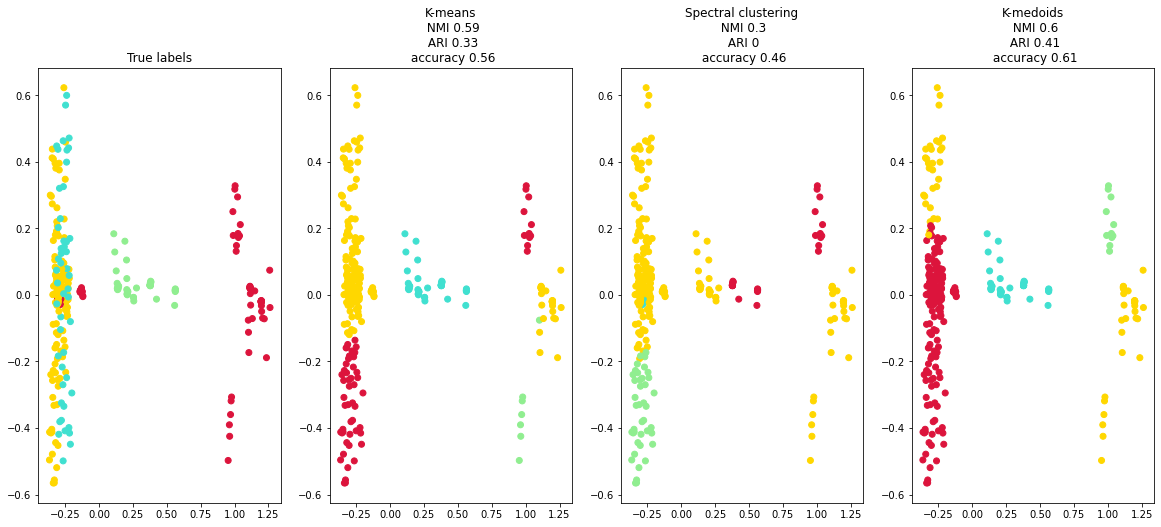

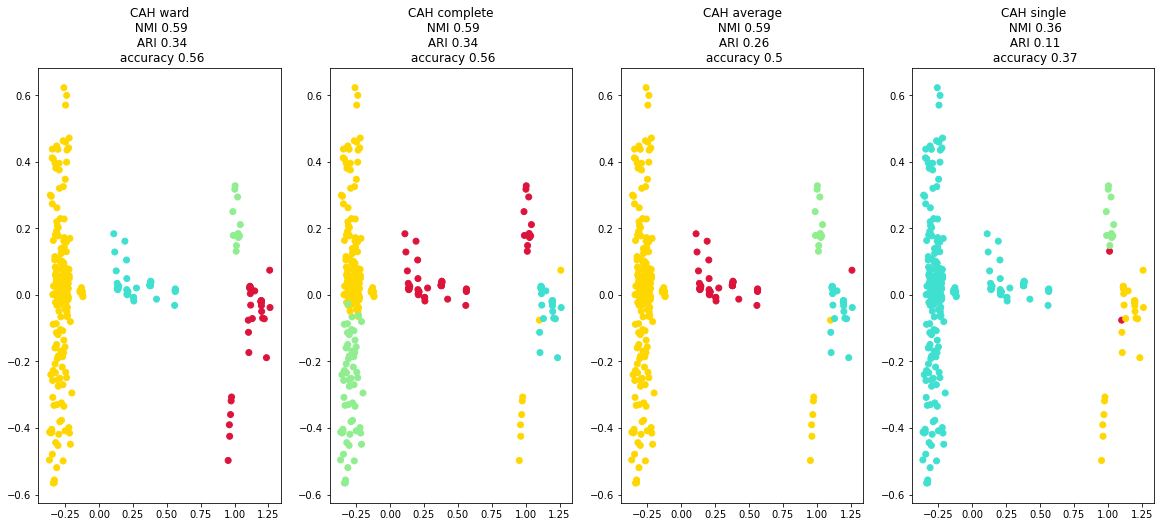

In [ ]:
eval_clustering_7(X_reduced, labels_int ,kmeans, spectral_clustering, kmedoids, cah_ward, cah_complete, cah_average,
                  cah_single, "True labels", "K-means", "Spectral clustering", "K-medoids", "CAH ward", "CAH complete",
                  "CAH average", "CAH single")

### SOM

In [ ]:
!pip install rpy2

In [ ]:
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

In [ ]:
from rpy2.robjects.packages import importr
utils= importr('utils')

In [ ]:
utils.install_packages('FCPS', repos="https://cloud.r-project.org")

In [ ]:
fcps=importr('FCPS')

In [ ]:
utils.install_packages('kohonen')

In [ ]:
som=fcps.SOMclustering(X, ClusterNo=k, alpha=0.5)

In [ ]:
pred_labels= som[0]

In [ ]:
normalized_mutual_info_score(labels_int, pred_labels)

0.5758332986264423

In [ ]:
adjusted_rand_score(pred_labels, labels_int)

0.36463456378199355

In [ ]:
accuracy(pred_labels, labels_int)

0.5504322766570605

## Clustering sur les données réduites

### Réduction de dimension des données

In [ ]:
#PCA
X_reduced_PCA =PCA(n_components=2, whiten=False, random_state=42).fit_transform(df_data)
#t-SNE
X_reduced_TSNE =TSNE(n_components=2, random_state=42).fit_transform(df_data)
#UMAP
X_reduced_UMAP =UMAP(n_components=2, random_state=42).fit_transform(df_data)
#Authoencoder
X_reduced_autoencoder = autoencoder(X.astype("float32"), 2, seed=42)



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
100%|██████████| 50/50 [00:00<00:00, 107.93it/s]


### ACP

In [ ]:
#Kmeans
kmeans_pred_labels=KMeans(k, random_state=42).fit(X_reduced_PCA).labels_
kmeans={"labels": kmeans_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmeans_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmeans_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmeans_pred_labels, labels_int),2)}

In [ ]:
#Spectral clustering
sepectral_pred_labels=SpectralClustering(k, affinity='nearest_neighbors', n_neighbors=10, random_state=42).fit(X_reduced_PCA).labels_

spectral_clustering= {"labels": sepectral_pred_labels,
                      "NMI": round(normalized_mutual_info_score(sepectral_pred_labels, labels_int),2),
                      "ARI": round(adjusted_rand_score(sepectral_pred_labels, labels_int),2),
                      "accuracy": round(accuracy(sepectral_pred_labels, labels_int),2)}

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


In [ ]:
#kmedois
kmedoids_pred_labels = KMedoids(n_clusters=k,method='pam', random_state=42).fit(X_reduced_PCA).labels_
kmedoids={"labels": kmedoids_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmedoids_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmedoids_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmedoids_pred_labels, labels_int),2)}

In [ ]:
#CAH with ward aggregation criteria
cah_ward_pred_labels=AgglomerativeClustering(k, linkage = 'ward').fit(X_reduced_PCA).labels_

cah_ward= {"labels": cah_ward_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_ward_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_ward_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_ward_pred_labels, labels_int),2)}

In [ ]:
#CAH with complete aggregation criteria
cah_complete_pred_labels=AgglomerativeClustering(k, linkage = 'complete').fit(X_reduced_PCA).labels_

cah_complete= {"labels": cah_complete_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_complete_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_complete_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_complete_pred_labels, labels_int),2)}

In [ ]:
#CAH with average aggregation criteria
cah_average_pred_labels=AgglomerativeClustering(k, linkage = 'average').fit(X_reduced_PCA).labels_

cah_average= {"labels": cah_average_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_average_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_average_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_average_pred_labels, labels_int),2)}

In [ ]:
#CAH with single aggregation criteria
cah_single_pred_labels=AgglomerativeClustering(k, linkage = 'single').fit(X_reduced_PCA).labels_

cah_single= {"labels": cah_single_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_single_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_single_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_single_pred_labels, labels_int),2)}

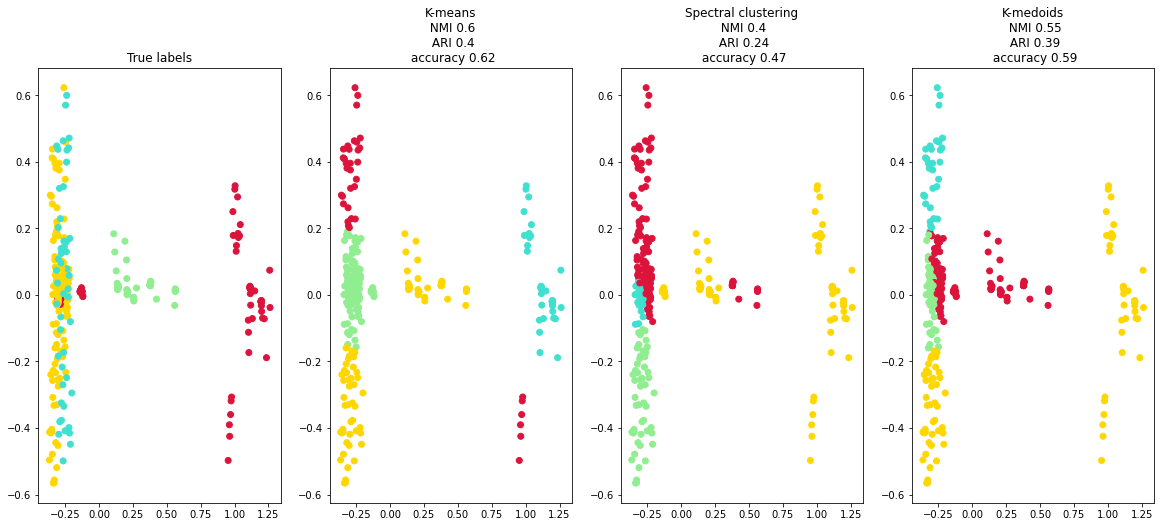

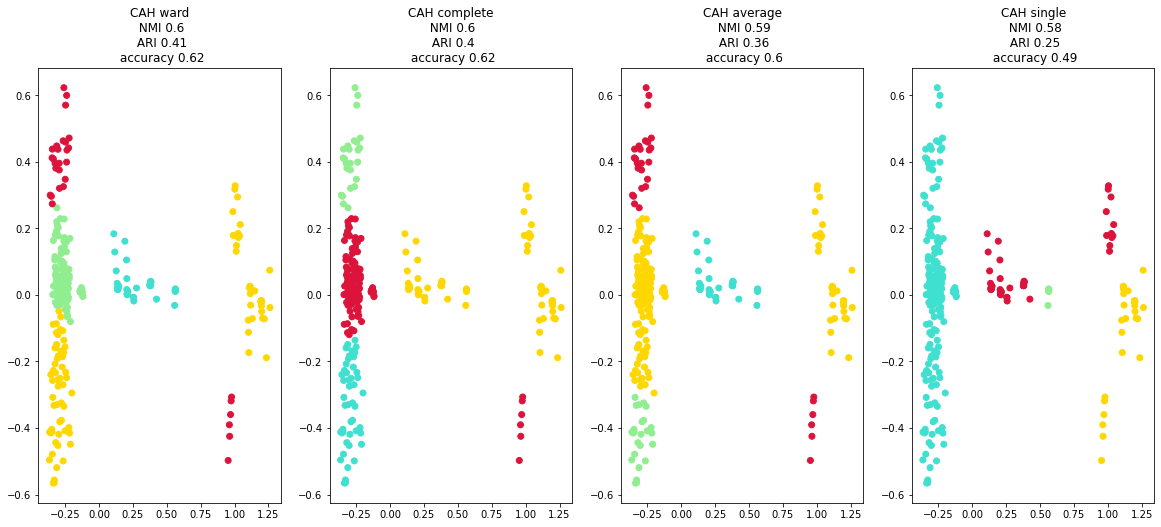

In [ ]:
eval_clustering_7(X_reduced_PCA, labels_int ,kmeans, spectral_clustering, kmedoids, cah_ward, cah_complete, cah_average,
                  cah_single, "True labels", "K-means", "Spectral clustering", "K-medoids", "CAH ward", "CAH complete",
                  "CAH average", "CAH single")

### t-SNE

In [ ]:
#Kmeans
kmeans_pred_labels=KMeans(k, random_state=42).fit(X_reduced_TSNE).labels_
kmeans={"labels": kmeans_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmeans_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmeans_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmeans_pred_labels, labels_int),2)}

In [ ]:
#Spectral clustering
sepectral_pred_labels=SpectralClustering(k, affinity='nearest_neighbors', n_neighbors=10, random_state=42).fit(X_reduced_TSNE).labels_

spectral_clustering= {"labels": sepectral_pred_labels,
                      "NMI": round(normalized_mutual_info_score(sepectral_pred_labels, labels_int),2),
                      "ARI": round(adjusted_rand_score(sepectral_pred_labels, labels_int),2),
                      "accuracy": round(accuracy(sepectral_pred_labels, labels_int),2)}

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


In [ ]:
#HDBSCAN
hdbscan_pred_labels=hdbscan.HDBSCAN(algorithm='best', alpha=1.0, leaf_size=40, cluster_selection_method='eom', metric='euclidean').fit(X_reduced_TSNE).labels_

hdbscan_= {"labels": hdbscan_pred_labels,
          "NMI": round(normalized_mutual_info_score(hdbscan_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(hdbscan_pred_labels, labels_int),2),
          "accuracy": round(accuracy(hdbscan_pred_labels, labels_int),2)}

In [ ]:
#kmedois
kmedoids_pred_labels = KMedoids(n_clusters=k,method='pam', random_state=42).fit(df_data).fit(X_reduced_TSNE).labels_
kmedoids={"labels": kmedoids_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmedoids_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmedoids_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmedoids_pred_labels, labels_int),2)}

In [ ]:
#CAH with ward aggregation criteria
cah_ward_pred_labels=AgglomerativeClustering(k, linkage = 'ward').fit(X_reduced_TSNE).labels_

cah_ward= {"labels": cah_ward_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_ward_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_ward_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_ward_pred_labels, labels_int),2)}

In [ ]:
#CAH with complete aggregation criteria
cah_complete_pred_labels=AgglomerativeClustering(k, linkage = 'complete').fit(X_reduced_TSNE).labels_

cah_complete= {"labels": cah_complete_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_complete_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_complete_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_complete_pred_labels, labels_int),2)}

In [ ]:
#CAH with average aggregation criteria
cah_average_pred_labels=AgglomerativeClustering(k, linkage = 'average').fit(X_reduced_TSNE).labels_

cah_average= {"labels": cah_average_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_average_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_average_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_average_pred_labels, labels_int),2)}

In [ ]:
#CAH with single aggregation criteria
cah_single_pred_labels=AgglomerativeClustering(k, linkage = 'single').fit(X_reduced_TSNE).labels_

cah_single= {"labels": cah_single_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_single_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_single_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_single_pred_labels, labels_int),2)}

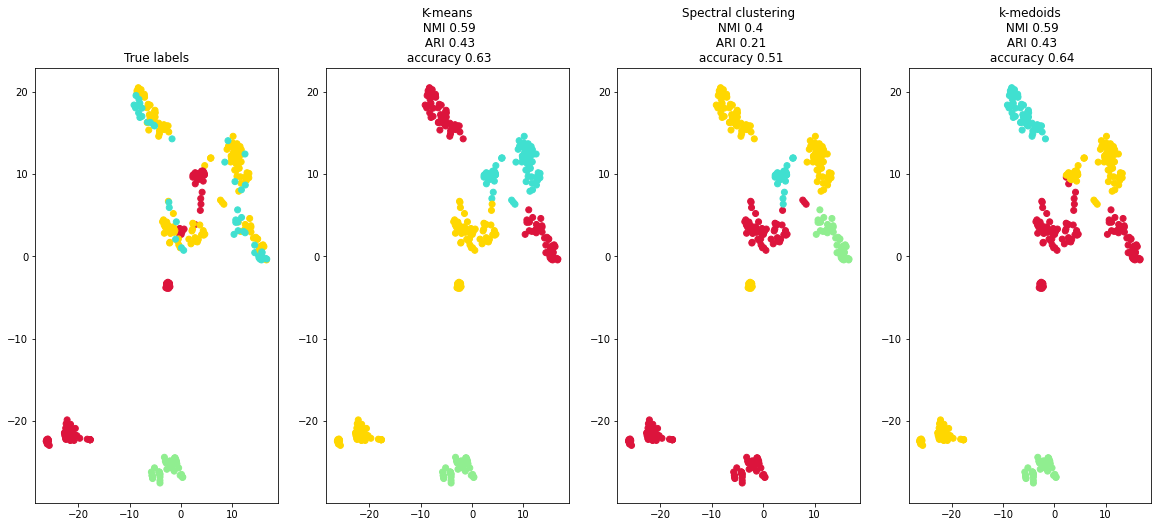

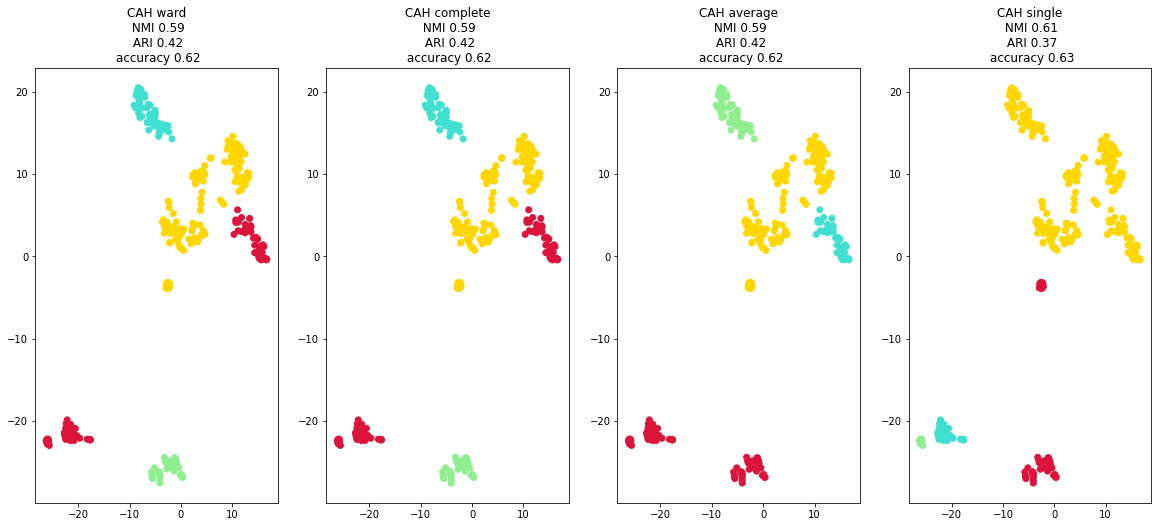

In [ ]:
eval_clustering_7(X_reduced_TSNE, labels_int ,kmeans, spectral_clustering, kmedoids, cah_ward, cah_complete, cah_average,
                  cah_single, "True labels", "K-means", "Spectral clustering", "k-medoids", "CAH ward", "CAH complete",
                  "CAH average", "CAH single")

### UMAP

In [ ]:
#Kmeans
kmeans_pred_labels=KMeans(k, random_state=42).fit(X_reduced_UMAP).labels_
kmeans={"labels": kmeans_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmeans_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmeans_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmeans_pred_labels, labels_int),2)}

In [ ]:
#Spectral clustering
sepectral_pred_labels=SpectralClustering(k, affinity='nearest_neighbors', n_neighbors=10, random_state=42).fit(X_reduced_UMAP).labels_

spectral_clustering= {"labels": sepectral_pred_labels,
                      "NMI": round(normalized_mutual_info_score(sepectral_pred_labels, labels_int),2),
                      "ARI": round(adjusted_rand_score(sepectral_pred_labels, labels_int),2),
                      "accuracy": round(accuracy(sepectral_pred_labels, labels_int),2)}

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


In [ ]:
#kmedois
kmedoids_pred_labels = KMedoids(n_clusters=k,method='pam', random_state=42).fit(df_data).fit(X_reduced_UMAP).labels_
kmedoids={"labels": kmedoids_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmedoids_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmedoids_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmedoids_pred_labels, labels_int),2)}

In [ ]:
#HDBSCAN
hdbscan_pred_labels=hdbscan.HDBSCAN(algorithm='best', alpha=1.0, leaf_size=40, cluster_selection_method='eom', metric='euclidean').fit(X_reduced_UMAP).labels_

hdbscan_= {"labels": hdbscan_pred_labels,
          "NMI": round(normalized_mutual_info_score(hdbscan_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(hdbscan_pred_labels, labels_int),2),
          "accuracy": round(accuracy(hdbscan_pred_labels, labels_int),2)}

In [ ]:
#CAH with ward aggregation criteria
cah_ward_pred_labels=AgglomerativeClustering(k, linkage = 'ward').fit(X_reduced_UMAP).labels_

cah_ward= {"labels": cah_ward_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_ward_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_ward_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_ward_pred_labels, labels_int),2)}

In [ ]:
#CAH with complete aggregation criteria
cah_complete_pred_labels=AgglomerativeClustering(k, linkage = 'complete').fit(X_reduced_UMAP).labels_

cah_complete= {"labels": cah_complete_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_complete_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_complete_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_complete_pred_labels, labels_int),2)}

In [ ]:
#CAH with average aggregation criteria
cah_average_pred_labels=AgglomerativeClustering(k, linkage = 'average').fit(X_reduced_UMAP).labels_

cah_average= {"labels": cah_average_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_average_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_average_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_average_pred_labels, labels_int),2)}

In [ ]:
#CAH with single aggregation criteria
cah_single_pred_labels=AgglomerativeClustering(k, linkage = 'single').fit(X_reduced_UMAP).labels_

cah_single= {"labels": cah_single_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_single_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_single_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_single_pred_labels, labels_int),2)}

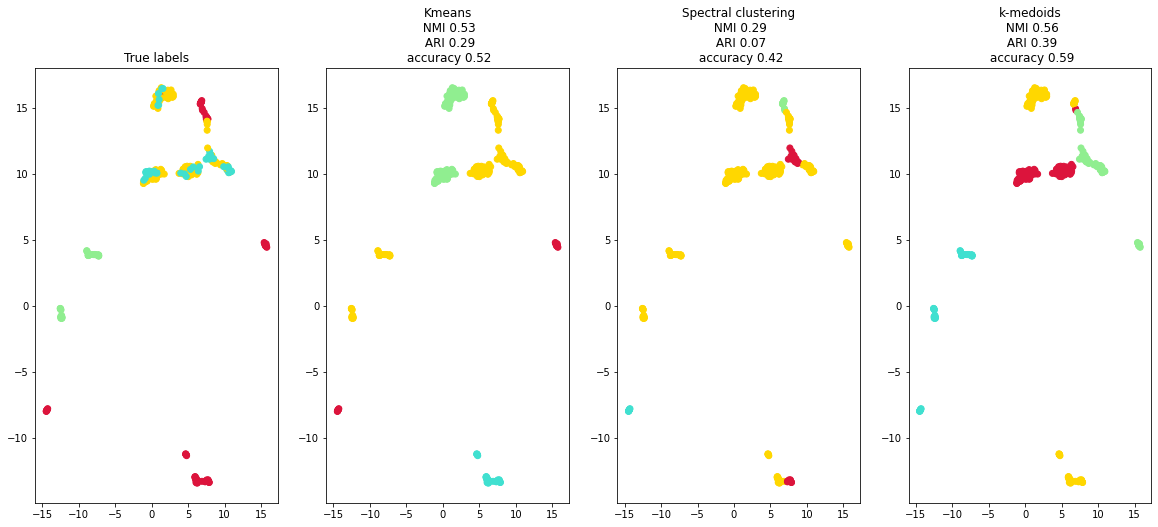

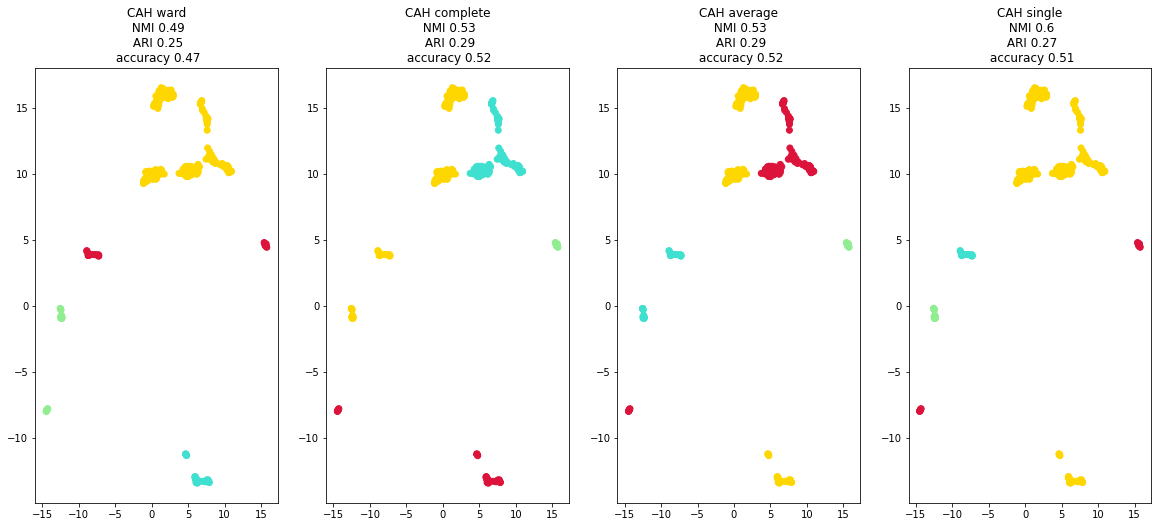

In [ ]:
eval_clustering_7(X_reduced_UMAP, labels_int ,kmeans, spectral_clustering, kmedoids, cah_ward, cah_complete, cah_average,
                  cah_single, "True labels", "Kmeans", "Spectral clustering", "k-medoids", "CAH ward", "CAH complete",
                  "CAH average", "CAH single")

### Autoencodeur

In [ ]:
#Kmeans
kmeans_pred_labels=KMeans(k, random_state=42).fit(X_reduced_autoencoder).labels_
kmeans={"labels": kmeans_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmeans_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmeans_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmeans_pred_labels, labels_int),2)}

In [ ]:
#Spectral clustering
sepectral_pred_labels=SpectralClustering(k, affinity='nearest_neighbors', n_neighbors=10, random_state=42).fit(X_reduced_autoencoder).labels_

spectral_clustering= {"labels": sepectral_pred_labels,
                      "NMI": round(normalized_mutual_info_score(sepectral_pred_labels, labels_int),2),
                      "ARI": round(adjusted_rand_score(sepectral_pred_labels, labels_int),2),
                      "accuracy": round(accuracy(sepectral_pred_labels, labels_int),2)}

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


In [ ]:
#kmedois
kmedoids_pred_labels = KMedoids(n_clusters=k,method='pam', random_state=42).fit(df_data).fit(X_reduced_autoencoder).labels_
kmedoids={"labels": kmedoids_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmedoids_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmedoids_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmedoids_pred_labels, labels_int),2)}

In [ ]:
#HDBSCAN
hdbscan_pred_labels=hdbscan.HDBSCAN(algorithm='best', alpha=1.0, leaf_size=40, cluster_selection_method='eom', metric='euclidean').fit(X_reduced_autoencoder).labels_

hdbscan_= {"labels": hdbscan_pred_labels,
          "NMI": round(normalized_mutual_info_score(hdbscan_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(hdbscan_pred_labels, labels_int),2),
          "accuracy": round(accuracy(hdbscan_pred_labels, labels_int),2)}

In [ ]:
#CAH with ward aggregation criteria
cah_ward_pred_labels=AgglomerativeClustering(k, linkage = 'ward').fit(X_reduced_autoencoder).labels_

cah_ward= {"labels": cah_ward_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_ward_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_ward_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_ward_pred_labels, labels_int),2)}

In [ ]:
#CAH with complete aggregation criteria
cah_complete_pred_labels=AgglomerativeClustering(k, linkage = 'complete').fit(X_reduced_autoencoder).labels_

cah_complete= {"labels": cah_complete_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_complete_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_complete_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_complete_pred_labels, labels_int),2)}

In [ ]:
#CAH with average aggregation criteria
cah_average_pred_labels=AgglomerativeClustering(k, linkage = 'average').fit(X_reduced_autoencoder).labels_

cah_average= {"labels": cah_average_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_average_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_average_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_average_pred_labels, labels_int),2)}

In [ ]:
#CAH with single aggregation criteria
cah_single_pred_labels=AgglomerativeClustering(k, linkage = 'single').fit(X_reduced_autoencoder).labels_

cah_single= {"labels": cah_single_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_single_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_single_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_single_pred_labels, labels_int),2)}

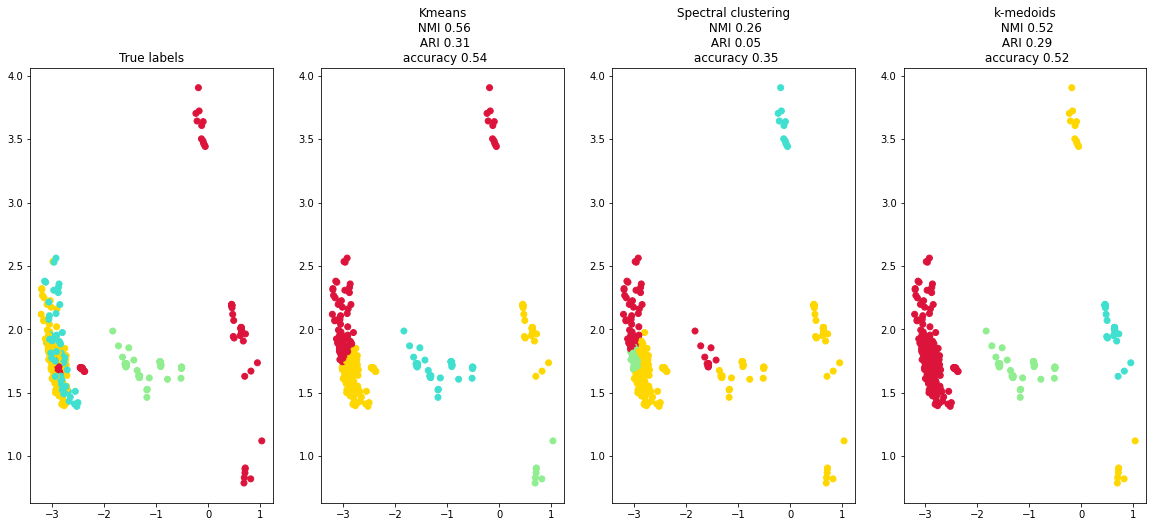

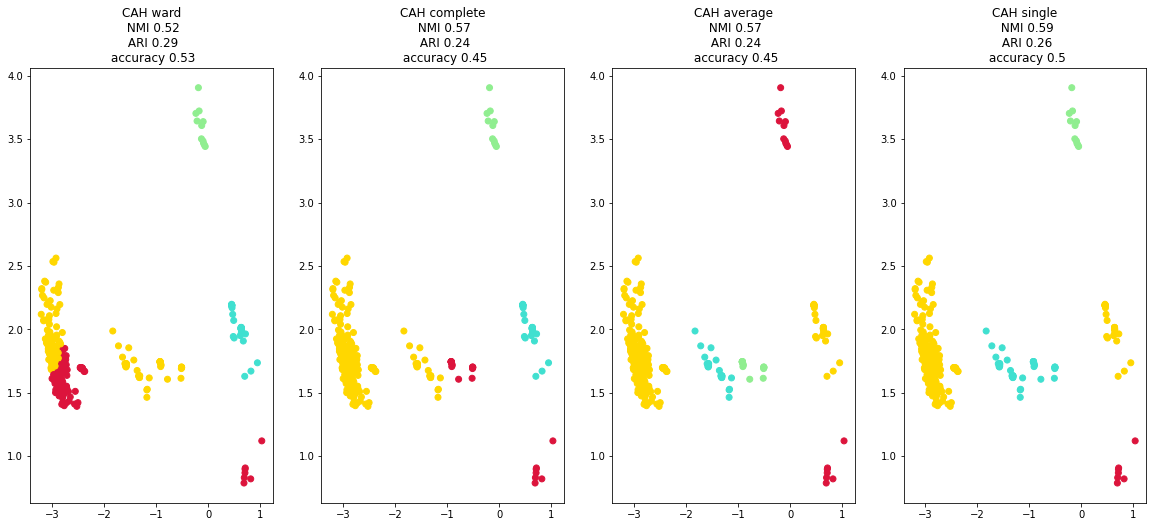

In [ ]:
eval_clustering_7(X_reduced_autoencoder, labels_int ,kmeans, spectral_clustering, kmedoids, cah_ward, cah_complete, cah_average,
                  cah_single, "True labels", "Kmeans", "Spectral clustering", "k-medoids", "CAH ward", "CAH complete",
                  "CAH average", "CAH single")

# Approche 3 : compresser les données avec la moyenne et formules de physique

## Importation des données

In [ ]:
! unzip data.zip

In [ ]:
#Importation des tableaux de l'accéleration estimée sur x,y,z
df_acce_x = pd.read_csv('acce_x.txt', sep=" ", header= None)
df_acce_y = pd.read_csv('acce_y.txt', sep=" ", header= None)
df_acce_z = pd.read_csv('acce_z.txt', sep=" ", header= None)

In [ ]:
#calculer ax², ay² , az²
df_acce_x = df_acce_x.pow(2)
df_acce_y = df_acce_y.pow(2)
df_acce_z = df_acce_z.pow(2)

In [ ]:
# df_acce contient  ax²+ay²+az²
df_add_acce = df_acce_x.add(df_acce_y, fill_value=0)
df_acce = df_add_acce.add(df_acce_z, fill_value=0)

In [ ]:
#df_acce contient acceleration totale = racine carré(ax²+ay²+az²)
df_acce = df_acce.apply(np.sqrt)

In [ ]:
#Importation des tableaux de l'accéleration mesurée sur x,y,z
df_accm_x = pd.read_csv('accm_x.txt', sep=" ", header= None)
df_accm_y = pd.read_csv('accm_y.txt', sep=" ",  header= None)
df_accm_z = pd.read_csv('accm_z.txt', sep=" ",  header= None)

In [ ]:
#calculer ax², ay² , az²
df_accm_x = df_accm_x.pow(2)
df_accm_y = df_accm_y.pow(2)
df_accm_z = df_accm_z.pow(2)

In [ ]:
# df_accm contient  ax²+ay²+az²
df_add_accm = df_accm_x.add(df_accm_y, fill_value=0)
df_accm = df_add_acce.add(df_accm_z, fill_value=0)

In [ ]:
#df_accm contient acceleration totale = racine carré(ax²+ay²+az²)
df_accm = df_accm.apply(np.sqrt)

In [ ]:
#Importation des tableaux de la vitesse sur x,y,z
df_vit_x = pd.read_csv('vit_x.txt', sep=" ", header= None)
df_vit_y = pd.read_csv('vit_y.txt', sep=" ", header= None)
df_vit_z = pd.read_csv('vit_z.txt', sep=" ", header= None)

In [ ]:
#calculer vx², vy² , vz²
df_vit_x = df_vit_x.pow(2)
df_vit_y = df_vit_y.pow(2)
df_vit_z = df_vit_z.pow(2)

In [ ]:
# df_vit contient  vx²+vy²+vz²
df_add_vit = df_vit_x.add(df_vit_y, fill_value=0)
df_vit = df_add_vit.add(df_vit_z, fill_value=0)

In [ ]:
#df_vit contient acceleration totale = racine carré(vx²+vy²+vz²)
df_vit = df_vit.apply(np.sqrt)

In [ ]:
#Importation du tableau de label
df_lab = pd.read_csv('lab.txt', sep=" ", header= None)
#Convertir df_lab to numpay array
labels_int = df_lab[0].to_numpy()

In [ ]:
#definition du data frame qui aura en colonnes les 347 individus et en colonnes les 3 variables
column_names = ["acce", "accm","vit"]
df_data = pd.DataFrame(columns = column_names)

In [ ]:
#Remplir le dataframe avec la moyenne de chaque ligne pour chaque variable
df_data['acce'] = df_acce.mean(axis=1)
df_data['accm'] = df_accm.mean(axis=1)
df_data['vit'] = df_vit.mean(axis=1)

In [ ]:
#nombre de classes
k= 6

In [ ]:
X = df_data.to_numpy()

In [ ]:
df_data.shape

(347, 3)

## Clustering sur les données originales

### k-means

In [ ]:
#Kmeans
kmeans_pred_labels=KMeans(k, random_state=42).fit(df_data).labels_
kmeans={"labels": kmeans_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmeans_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmeans_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmeans_pred_labels, labels_int),2)}

### Clustering Spectral

In [ ]:
#Spectral clustering
sepectral_pred_labels=SpectralClustering(k, affinity='nearest_neighbors', n_neighbors=5, random_state=42).fit(df_data).labels_

spectral_clustering= {"labels": sepectral_pred_labels,
                      "NMI": round(normalized_mutual_info_score(sepectral_pred_labels, labels_int),2),
                      "ARI": round(adjusted_rand_score(sepectral_pred_labels, labels_int)),
                      "accuracy": round(accuracy(sepectral_pred_labels, labels_int),2)}


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


### k-medoids with PAM

In [ ]:
kmedoids_pred_labels = KMedoids(n_clusters=k,method='pam', random_state=42).fit(df_data).fit(df_data).labels_
kmedoids={"labels": kmedoids_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmedoids_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmedoids_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmedoids_pred_labels, labels_int),2)}

### CAH

In [ ]:
#CAH with ward aggregation criteria
cah_ward_pred_labels=AgglomerativeClustering(k, linkage = 'ward').fit(df_data).labels_

cah_ward= {"labels": cah_ward_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_ward_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_ward_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_ward_pred_labels, labels_int),2)}

In [ ]:
#CAH with complete aggregation criteria
cah_complete_pred_labels=AgglomerativeClustering(k, linkage = 'complete').fit(df_data).labels_

cah_complete= {"labels": cah_complete_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_complete_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_complete_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_complete_pred_labels, labels_int),2)}

In [ ]:
#CAH with average aggregation criteria
cah_average_pred_labels=AgglomerativeClustering(k, linkage = 'average').fit(df_data).labels_

cah_average= {"labels": cah_average_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_average_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_average_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_average_pred_labels, labels_int),2)}

In [ ]:
#CAH with single aggregation criteria
cah_single_pred_labels=AgglomerativeClustering(k, linkage = 'single').fit(df_data).labels_

cah_single= {"labels": cah_single_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_single_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_single_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_single_pred_labels, labels_int),2)}

In [ ]:
#PCA for visualisation
X_reduced=PCA(n_components=2, whiten=False, random_state=42).fit_transform(df_data)

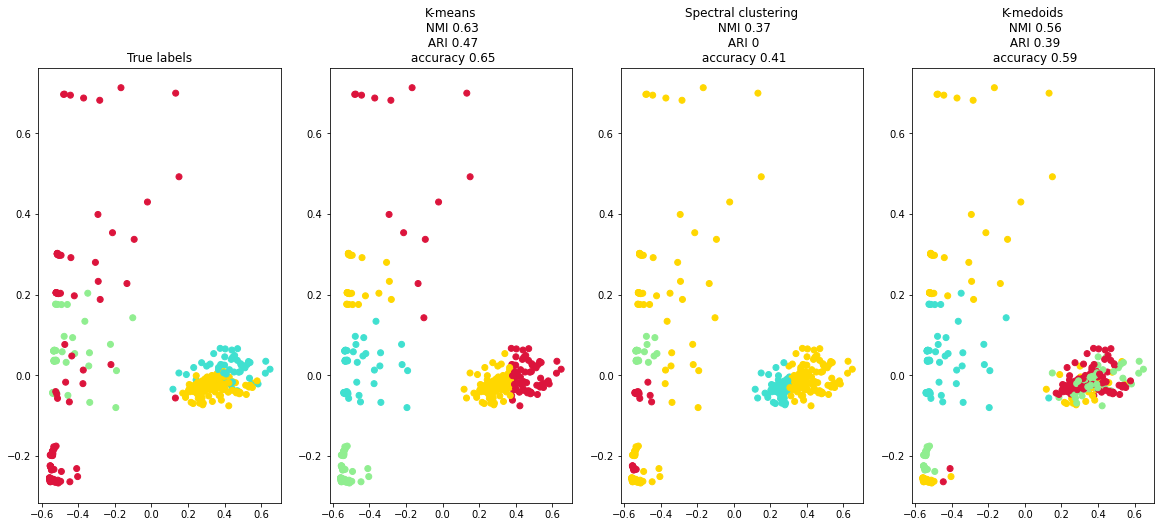

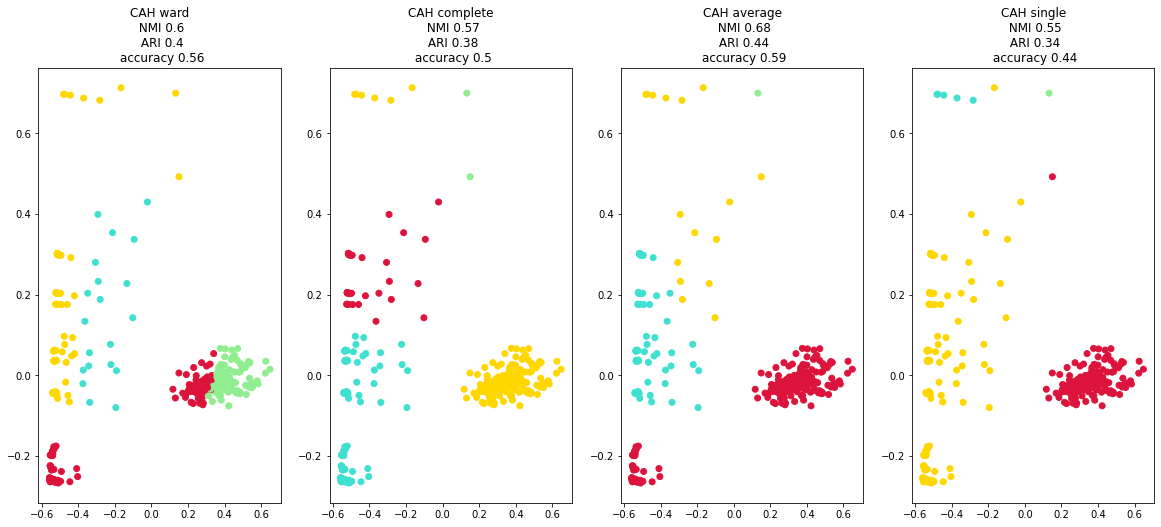

In [ ]:
eval_clustering_7(X_reduced, labels_int ,kmeans, spectral_clustering, kmedoids, cah_ward, cah_complete, cah_average,
                  cah_single, "True labels", "K-means", "Spectral clustering", "K-medoids", "CAH ward", "CAH complete",
                  "CAH average", "CAH single")

### SOM

In [ ]:
!pip install rpy2

In [ ]:
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

In [ ]:
from rpy2.robjects.packages import importr
utils= importr('utils')

In [ ]:
utils.install_packages('FCPS', repos="https://cloud.r-project.org")

In [ ]:
fcps=importr('FCPS')

In [ ]:
utils.install_packages('kohonen')

In [ ]:
som=fcps.SOMclustering(X, ClusterNo=k, alpha=0.5)

In [ ]:
pred_labels= som[0]

In [ ]:
normalized_mutual_info_score(labels_int, pred_labels)

0.6092333470264284

In [ ]:
adjusted_rand_score(pred_labels, labels_int)

0.4450440119264874

In [ ]:
accuracy(pred_labels, labels_int)

0.5994236311239193

## Clustering sur les données réduites

### Réduction de dimension des données

In [ ]:
#PCA
X_reduced_PCA =PCA(n_components=2, whiten=False, random_state=42).fit_transform(df_data)
#t-SNE
X_reduced_TSNE =TSNE(n_components=2, random_state=42).fit_transform(df_data)
#UMAP
X_reduced_UMAP =UMAP(n_components=2, random_state=42).fit_transform(df_data)
#Authoencoder
X_reduced_autoencoder = autoencoder(X.astype("float32"), 2, seed=42)



### ACP

In [ ]:
#Kmeans
kmeans_pred_labels=KMeans(k, random_state=42).fit(X_reduced_PCA).labels_
kmeans={"labels": kmeans_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmeans_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmeans_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmeans_pred_labels, labels_int),2)}

In [ ]:
#Spectral clustering
sepectral_pred_labels=SpectralClustering(k, affinity='nearest_neighbors', n_neighbors=10, random_state=42).fit(X_reduced_PCA).labels_

spectral_clustering= {"labels": sepectral_pred_labels,
                      "NMI": round(normalized_mutual_info_score(sepectral_pred_labels, labels_int),2),
                      "ARI": round(adjusted_rand_score(sepectral_pred_labels, labels_int),2),
                      "accuracy": round(accuracy(sepectral_pred_labels, labels_int),2)}

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


In [ ]:
#kmedois
kmedoids_pred_labels = KMedoids(n_clusters=k,method='pam', random_state=42).fit(X_reduced_PCA).labels_
kmedoids={"labels": kmedoids_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmedoids_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmedoids_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmedoids_pred_labels, labels_int),2)}

In [ ]:
#CAH with ward aggregation criteria
cah_ward_pred_labels=AgglomerativeClustering(k, linkage = 'ward').fit(X_reduced_PCA).labels_

cah_ward= {"labels": cah_ward_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_ward_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_ward_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_ward_pred_labels, labels_int),2)}

In [ ]:
#CAH with complete aggregation criteria
cah_complete_pred_labels=AgglomerativeClustering(k, linkage = 'complete').fit(X_reduced_PCA).labels_

cah_complete= {"labels": cah_complete_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_complete_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_complete_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_complete_pred_labels, labels_int),2)}

In [ ]:
#CAH with average aggregation criteria
cah_average_pred_labels=AgglomerativeClustering(k, linkage = 'average').fit(X_reduced_PCA).labels_

cah_average= {"labels": cah_average_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_average_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_average_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_average_pred_labels, labels_int),2)}

In [ ]:
#CAH with single aggregation criteria
cah_single_pred_labels=AgglomerativeClustering(k, linkage = 'single').fit(X_reduced_PCA).labels_

cah_single= {"labels": cah_single_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_single_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_single_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_single_pred_labels, labels_int),2)}

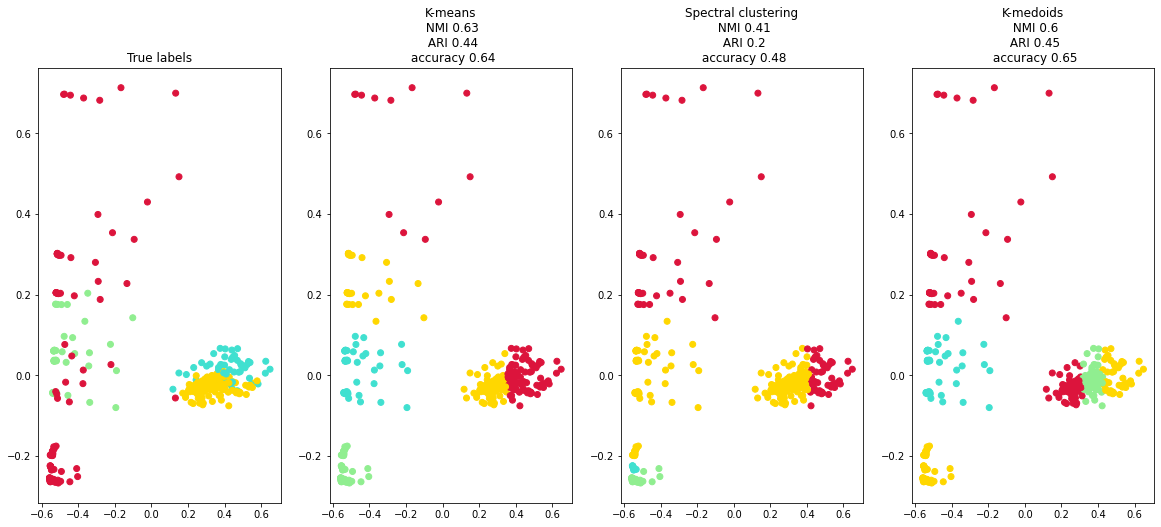

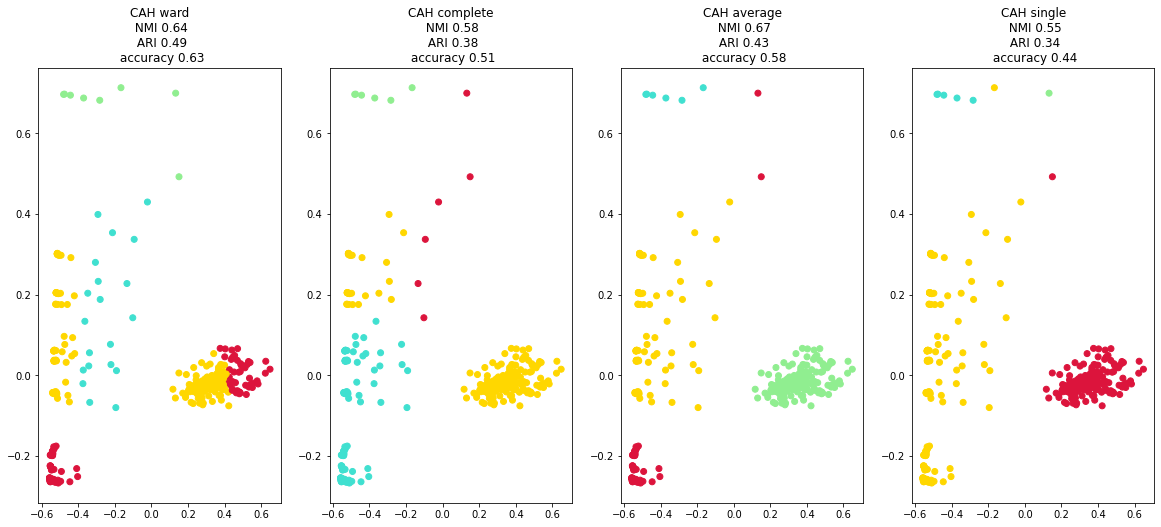

In [ ]:
eval_clustering_7(X_reduced_PCA, labels_int ,kmeans, spectral_clustering, kmedoids, cah_ward, cah_complete, cah_average,
                  cah_single, "True labels", "K-means", "Spectral clustering", "K-medoids", "CAH ward", "CAH complete",
                  "CAH average", "CAH single")

### t-SNE

In [ ]:
#Kmeans
kmeans_pred_labels=KMeans(k, random_state=42).fit(X_reduced_TSNE).labels_
kmeans={"labels": kmeans_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmeans_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmeans_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmeans_pred_labels, labels_int),2)}

In [ ]:
#Spectral clustering
sepectral_pred_labels=SpectralClustering(k, affinity='nearest_neighbors', n_neighbors=10, random_state=42).fit(X_reduced_TSNE).labels_

spectral_clustering= {"labels": sepectral_pred_labels,
                      "NMI": round(normalized_mutual_info_score(sepectral_pred_labels, labels_int),2),
                      "ARI": round(adjusted_rand_score(sepectral_pred_labels, labels_int),2),
                      "accuracy": round(accuracy(sepectral_pred_labels, labels_int),2)}

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


In [ ]:
#HDBSCAN
hdbscan_pred_labels=hdbscan.HDBSCAN(algorithm='best', alpha=1.0, leaf_size=40, cluster_selection_method='eom', metric='euclidean').fit(X_reduced_TSNE).labels_

hdbscan_= {"labels": hdbscan_pred_labels,
          "NMI": round(normalized_mutual_info_score(hdbscan_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(hdbscan_pred_labels, labels_int),2),
          "accuracy": round(accuracy(hdbscan_pred_labels, labels_int),2)}

In [ ]:
#kmedois
kmedoids_pred_labels = KMedoids(n_clusters=k,method='pam', random_state=42).fit(df_data).fit(X_reduced_TSNE).labels_
kmedoids={"labels": kmedoids_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmedoids_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmedoids_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmedoids_pred_labels, labels_int),2)}

In [ ]:
#CAH with ward aggregation criteria
cah_ward_pred_labels=AgglomerativeClustering(k, linkage = 'ward').fit(X_reduced_TSNE).labels_

cah_ward= {"labels": cah_ward_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_ward_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_ward_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_ward_pred_labels, labels_int),2)}

In [ ]:
#CAH with complete aggregation criteria
cah_complete_pred_labels=AgglomerativeClustering(k, linkage = 'complete').fit(X_reduced_TSNE).labels_

cah_complete= {"labels": cah_complete_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_complete_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_complete_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_complete_pred_labels, labels_int),2)}

In [ ]:
#CAH with average aggregation criteria
cah_average_pred_labels=AgglomerativeClustering(k, linkage = 'average').fit(X_reduced_TSNE).labels_

cah_average= {"labels": cah_average_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_average_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_average_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_average_pred_labels, labels_int),2)}

In [ ]:
#CAH with single aggregation criteria
cah_single_pred_labels=AgglomerativeClustering(k, linkage = 'single').fit(X_reduced_TSNE).labels_

cah_single= {"labels": cah_single_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_single_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_single_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_single_pred_labels, labels_int),2)}

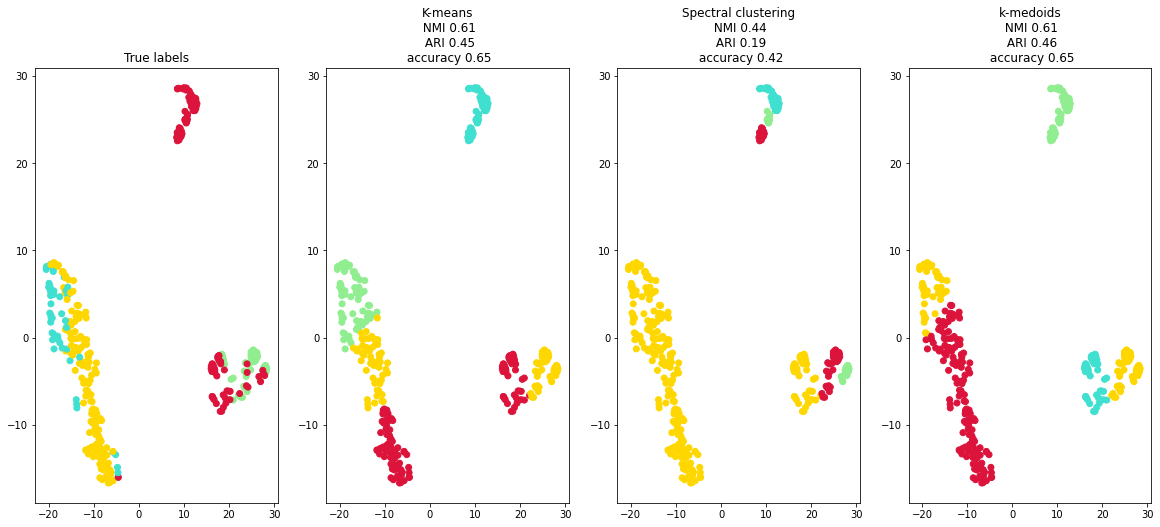

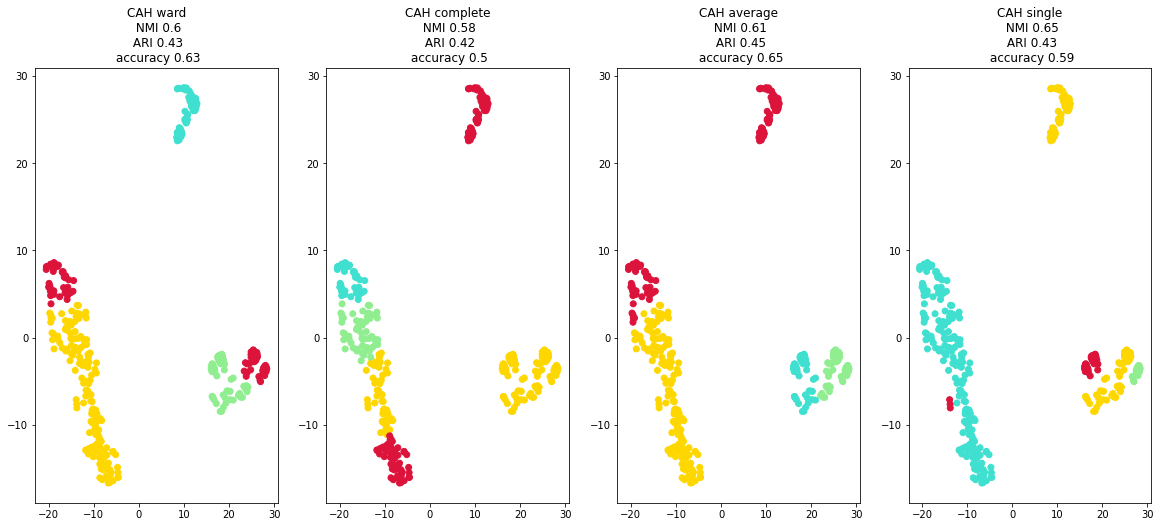

In [ ]:
eval_clustering_7(X_reduced_TSNE, labels_int ,kmeans, spectral_clustering, kmedoids, cah_ward, cah_complete, cah_average,
                  cah_single, "True labels", "K-means", "Spectral clustering", "k-medoids", "CAH ward", "CAH complete",
                  "CAH average", "CAH single")

### UMAP

In [ ]:
#Kmeans
kmeans_pred_labels=KMeans(k, random_state=42).fit(X_reduced_UMAP).labels_
kmeans={"labels": kmeans_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmeans_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmeans_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmeans_pred_labels, labels_int),2)}

In [ ]:
#Spectral clustering
sepectral_pred_labels=SpectralClustering(k, affinity='nearest_neighbors', n_neighbors=10, random_state=42).fit(X_reduced_UMAP).labels_

spectral_clustering= {"labels": sepectral_pred_labels,
                      "NMI": round(normalized_mutual_info_score(sepectral_pred_labels, labels_int),2),
                      "ARI": round(adjusted_rand_score(sepectral_pred_labels, labels_int),2),
                      "accuracy": round(accuracy(sepectral_pred_labels, labels_int),2)}

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


In [ ]:
#kmedois
kmedoids_pred_labels = KMedoids(n_clusters=k,method='pam', random_state=42).fit(df_data).fit(X_reduced_UMAP).labels_
kmedoids={"labels": kmedoids_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmedoids_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmedoids_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmedoids_pred_labels, labels_int),2)}

In [ ]:
#HDBSCAN
hdbscan_pred_labels=hdbscan.HDBSCAN(algorithm='best', alpha=1.0, leaf_size=40, cluster_selection_method='eom', metric='euclidean').fit(X_reduced_UMAP).labels_

hdbscan_= {"labels": hdbscan_pred_labels,
          "NMI": round(normalized_mutual_info_score(hdbscan_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(hdbscan_pred_labels, labels_int),2),
          "accuracy": round(accuracy(hdbscan_pred_labels, labels_int),2)}

In [ ]:
#CAH with ward aggregation criteria
cah_ward_pred_labels=AgglomerativeClustering(k, linkage = 'ward').fit(X_reduced_UMAP).labels_

cah_ward= {"labels": cah_ward_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_ward_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_ward_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_ward_pred_labels, labels_int),2)}

In [ ]:
#CAH with complete aggregation criteria
cah_complete_pred_labels=AgglomerativeClustering(k, linkage = 'complete').fit(X_reduced_UMAP).labels_

cah_complete= {"labels": cah_complete_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_complete_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_complete_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_complete_pred_labels, labels_int),2)}

In [ ]:
#CAH with average aggregation criteria
cah_average_pred_labels=AgglomerativeClustering(k, linkage = 'average').fit(X_reduced_UMAP).labels_

cah_average= {"labels": cah_average_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_average_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_average_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_average_pred_labels, labels_int),2)}

In [ ]:
#CAH with single aggregation criteria
cah_single_pred_labels=AgglomerativeClustering(k, linkage = 'single').fit(X_reduced_UMAP).labels_

cah_single= {"labels": cah_single_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_single_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_single_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_single_pred_labels, labels_int),2)}

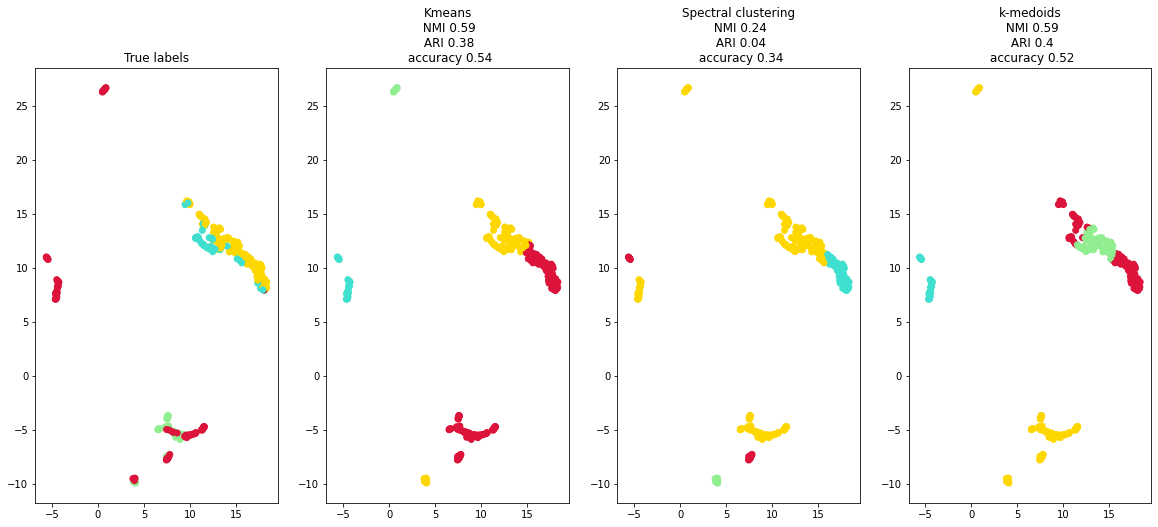

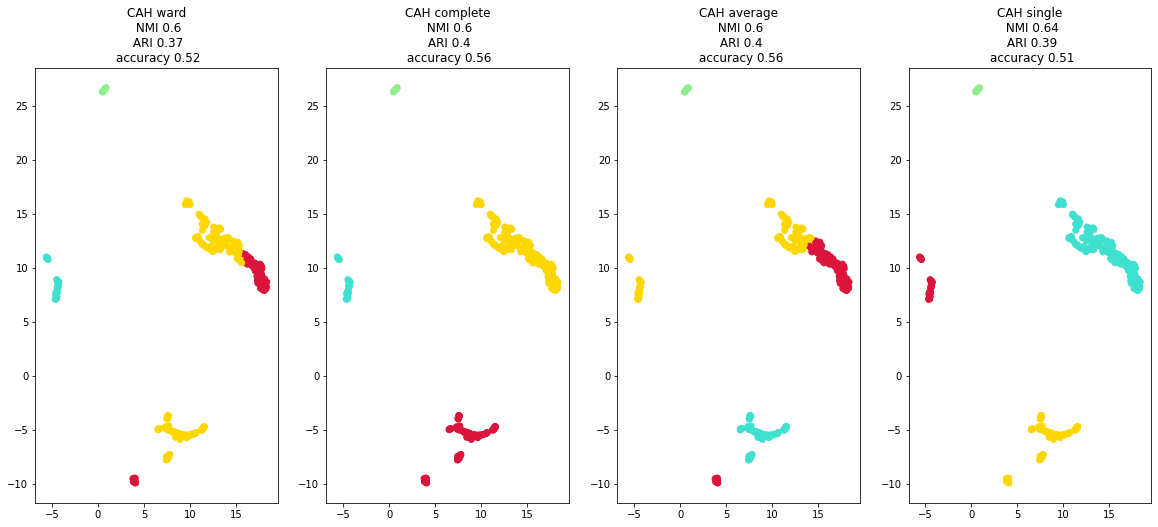

In [ ]:
eval_clustering_7(X_reduced_UMAP, labels_int ,kmeans, spectral_clustering, kmedoids, cah_ward, cah_complete, cah_average,
                  cah_single, "True labels", "Kmeans", "Spectral clustering", "k-medoids", "CAH ward", "CAH complete",
                  "CAH average", "CAH single")

### Autoencodeur

In [ ]:
#Kmeans
kmeans_pred_labels=KMeans(k, random_state=42).fit(X_reduced_autoencoder).labels_
kmeans={"labels": kmeans_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmeans_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmeans_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmeans_pred_labels, labels_int),2)}

In [ ]:
#Spectral clustering
sepectral_pred_labels=SpectralClustering(k, affinity='nearest_neighbors', n_neighbors=10, random_state=42).fit(X_reduced_autoencoder).labels_

spectral_clustering= {"labels": sepectral_pred_labels,
                      "NMI": round(normalized_mutual_info_score(sepectral_pred_labels, labels_int),2),
                      "ARI": round(adjusted_rand_score(sepectral_pred_labels, labels_int),2),
                      "accuracy": round(accuracy(sepectral_pred_labels, labels_int),2)}

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


In [ ]:
#kmedois
kmedoids_pred_labels = KMedoids(n_clusters=k,method='pam', random_state=42).fit(df_data).fit(X_reduced_autoencoder).labels_
kmedoids={"labels": kmedoids_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmedoids_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmedoids_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmedoids_pred_labels, labels_int),2)}

In [ ]:
#HDBSCAN
hdbscan_pred_labels=hdbscan.HDBSCAN(algorithm='best', alpha=1.0, leaf_size=40, cluster_selection_method='eom', metric='euclidean').fit(X_reduced_autoencoder).labels_

hdbscan_= {"labels": hdbscan_pred_labels,
          "NMI": round(normalized_mutual_info_score(hdbscan_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(hdbscan_pred_labels, labels_int),2),
          "accuracy": round(accuracy(hdbscan_pred_labels, labels_int),2)}

In [ ]:
#CAH with ward aggregation criteria
cah_ward_pred_labels=AgglomerativeClustering(k, linkage = 'ward').fit(X_reduced_autoencoder).labels_

cah_ward= {"labels": cah_ward_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_ward_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_ward_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_ward_pred_labels, labels_int),2)}

In [ ]:
#CAH with complete aggregation criteria
cah_complete_pred_labels=AgglomerativeClustering(k, linkage = 'complete').fit(X_reduced_autoencoder).labels_

cah_complete= {"labels": cah_complete_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_complete_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_complete_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_complete_pred_labels, labels_int),2)}

In [ ]:
#CAH with average aggregation criteria
cah_average_pred_labels=AgglomerativeClustering(k, linkage = 'average').fit(X_reduced_autoencoder).labels_

cah_average= {"labels": cah_average_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_average_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_average_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_average_pred_labels, labels_int),2)}

In [ ]:
#CAH with single aggregation criteria
cah_single_pred_labels=AgglomerativeClustering(k, linkage = 'single').fit(X_reduced_autoencoder).labels_

cah_single= {"labels": cah_single_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_single_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_single_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_single_pred_labels, labels_int),2)}

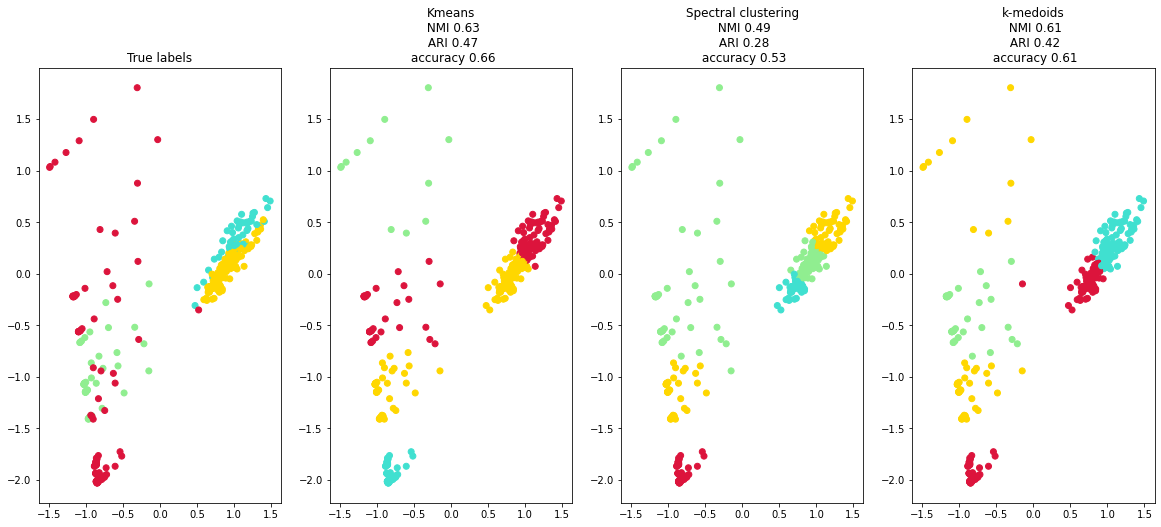

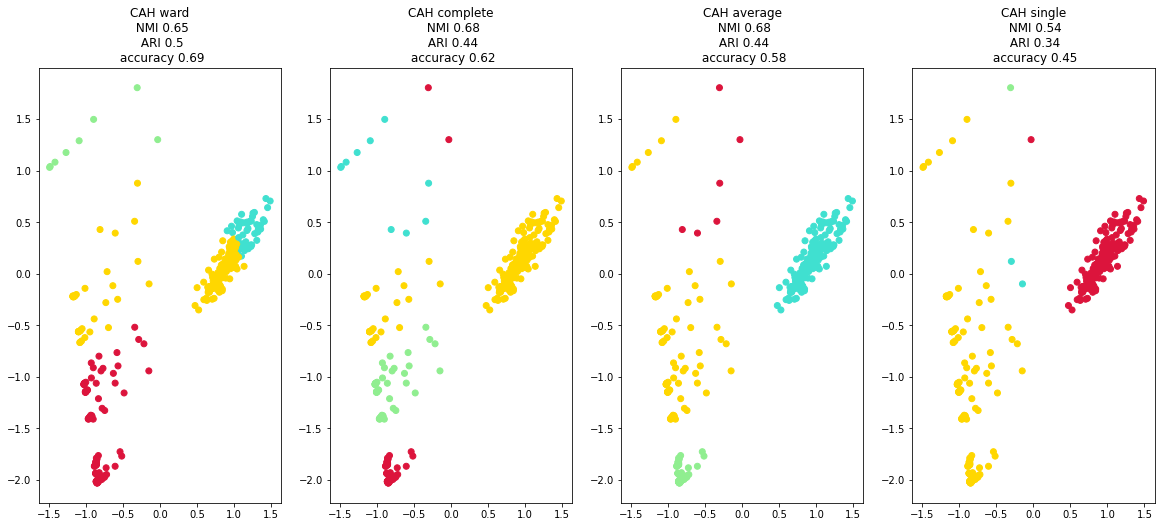

In [ ]:
eval_clustering_7(X_reduced_autoencoder, labels_int ,kmeans, spectral_clustering, kmedoids, cah_ward, cah_complete, cah_average,
                  cah_single, "True labels", "Kmeans", "Spectral clustering", "k-medoids", "CAH ward", "CAH complete",
                  "CAH average", "CAH single")

# Approche 4 : compresser les données avec les méthodes d'approximation des séries temporelles

## Importation des données

In [ ]:
! unzip data.zip

Archive:  data.zip
  inflating: vit_x.txt               
  inflating: vit_y.txt               
  inflating: vit_z.txt               
  inflating: accm_x.txt              
  inflating: accm_y.txt              
  inflating: accm_z.txt              
  inflating: lab.txt                 
  inflating: acce_x.txt              
  inflating: acce_y.txt              
  inflating: acce_z.txt              


In [ ]:
#Importation des tableaux de l'accéleration estimée sur x,y,z
df_acce_x = pd.read_csv('acce_x.txt', sep=" ", header= None)
df_acce_y = pd.read_csv('acce_y.txt', sep=" ", header= None)
df_acce_z = pd.read_csv('acce_z.txt', sep=" ", header= None)

In [ ]:
#Importation des tableaux de l'accéleration mesurée sur x,y,z
df_accm_x = pd.read_csv('accm_x.txt', sep=" ", header= None)
df_accm_y = pd.read_csv('accm_y.txt', sep=" ", header= None)
df_accm_z = pd.read_csv('accm_z.txt', sep=" ", header= None)

In [ ]:
#Importation des tableaux de la vitesse sur x,y,z
df_vit_x = pd.read_csv('vit_x.txt', sep=" ", header= None)
df_vit_y = pd.read_csv('vit_y.txt', sep=" ", header= None)
df_vit_z = pd.read_csv('vit_z.txt', sep=" ", header= None)

In [ ]:
#Importation du tableau de label
df_lab = pd.read_csv('lab.txt', sep=" ", header= None)
#Convertir df_lab to numpay array
labels_int = df_lab[0].to_numpy()

In [ ]:
#nombre de classes
k=6

In [ ]:
#Transformer tous les dataframes à des numpy arrays
df_acce_x_array = df_acce_x.to_numpy()
df_acce_y_array = df_acce_y.to_numpy()
df_acce_z_array = df_acce_z.to_numpy()

df_accm_x_array = df_accm_x.to_numpy()
df_accm_y_array = df_accm_y.to_numpy()
df_accm_z_array = df_accm_z.to_numpy()

df_vit_x_array = df_vit_x.to_numpy()
df_vit_y_array= df_vit_y.to_numpy()
df_vit_z_array= df_vit_z.to_numpy()

## Piecewise Aggregate Approximation

In [ ]:
!pip install pyts

     |████████████████████████████████| 2.5 MB 7.8 MB/s 


In [ ]:
from pyts.approximation import PiecewiseAggregateApproximation

transformer = PiecewiseAggregateApproximation(window_size=128)

In [ ]:
#transfomer le tableau de chaque variable individuellement
acce_x_transformed=transformer.transform(df_acce_x_array)
acce_y_transformed=transformer.transform(df_acce_y_array)
acce_z_transformed=transformer.transform(df_acce_z_array)

accm_x_transformed=transformer.transform(df_accm_x_array)
accm_y_transformed=transformer.transform(df_accm_y_array)
accm_z_transformed=transformer.transform(df_accm_z_array)

vit_x_transformed=transformer.transform(df_vit_x_array)
vit_y_transformed=transformer.transform(df_vit_y_array)
vit_z_transformed=transformer.transform(df_vit_z_array)

In [ ]:
df_acce_x_transformed = pd.DataFrame(data=acce_x_transformed, index=np.array(range(1, 348)),
          columns=np.array(range(1, 2)))
df_acce_y_transformed = pd.DataFrame(data=acce_y_transformed, index=np.array(range(1, 348)),
          columns=np.array(range(1, 2)))
df_acce_z_transformed = pd.DataFrame(data=acce_z_transformed, index=np.array(range(1, 348)),
          columns=np.array(range(1, 2)))

df_accm_x_transformed = pd.DataFrame(data=accm_x_transformed, index=np.array(range(1, 348)),
          columns=np.array(range(1, 2)))
df_accm_y_transformed = pd.DataFrame(data=accm_y_transformed, index=np.array(range(1, 348)),
          columns=np.array(range(1, 2)))
df_accm_z_transformed = pd.DataFrame(data=accm_z_transformed, index=np.array(range(1, 348)),
          columns=np.array(range(1, 2)))

df_vit_x_transformed = pd.DataFrame(data=vit_x_transformed, index=np.array(range(1, 348)),
          columns=np.array(range(1, 2)))
df_vit_y_transformed = pd.DataFrame(data=vit_y_transformed, index=np.array(range(1, 348)),
          columns=np.array(range(1, 2)))
df_vit_z_transformed = pd.DataFrame(data=vit_z_transformed, index=np.array(range(1, 348)),
          columns=np.array(range(1, 2)))


In [ ]:
frames= [df_acce_x_transformed, df_acce_y_transformed, df_acce_z_transformed, df_accm_x_transformed, df_accm_y_transformed, df_accm_z_transformed,
         df_vit_x_transformed, df_vit_y_transformed, df_vit_z_transformed]

In [ ]:
#Concaténer dans un seul dataframe
df=pd.concat(frames, axis=1)

In [ ]:
df.shape

(347, 9)

### Kmeans

In [ ]:
kmeans_pred_labels=KMeans(k, random_state=42).fit(df).labels_
kmeans={"labels": kmeans_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmeans_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmeans_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmeans_pred_labels, labels_int),2)}

### Spectral clustering

In [ ]:
sepectral_pred_labels=SpectralClustering(k, affinity='nearest_neighbors', n_neighbors=5, random_state=42).fit(df).labels_

spectral_clustering= {"labels": sepectral_pred_labels,
                      "NMI": round(normalized_mutual_info_score(sepectral_pred_labels, labels_int),2),
                      "ARI": round(adjusted_rand_score(sepectral_pred_labels, labels_int)),
                      "accuracy": round(accuracy(sepectral_pred_labels, labels_int),2)}


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


### Kmedoids

In [ ]:
kmedoids_pred_labels = KMedoids(n_clusters=k,method='pam', random_state=42).fit(df).labels_
kmedoids={"labels": kmedoids_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmedoids_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmedoids_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmedoids_pred_labels, labels_int),2)}

### CAH

In [ ]:
#CAH with ward aggregation criteria
cah_ward_pred_labels=AgglomerativeClustering(k, linkage = 'ward').fit(df).labels_

cah_ward= {"labels": cah_ward_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_ward_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_ward_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_ward_pred_labels, labels_int),2)}

In [ ]:
#CAH with complete aggregation criteria
cah_complete_pred_labels=AgglomerativeClustering(k, linkage = 'complete').fit(df).labels_

cah_complete= {"labels": cah_complete_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_complete_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_complete_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_complete_pred_labels, labels_int),2)}

In [ ]:
#CAH with average aggregation criteria
cah_average_pred_labels=AgglomerativeClustering(k, linkage = 'average').fit(df).labels_

cah_average= {"labels": cah_average_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_average_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_average_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_average_pred_labels, labels_int),2)}

In [ ]:
#CAH with single aggregation criteria
cah_single_pred_labels=AgglomerativeClustering(k, linkage = 'single').fit(df).labels_

cah_single= {"labels": cah_single_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_single_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_single_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_single_pred_labels, labels_int),2)}

### SOM

In [ ]:
som_pred_labels=fcps.SOMclustering(df.values, ClusterNo=k, alpha=0.5)[0]

som={"labels": som_pred_labels,
          "NMI": round(normalized_mutual_info_score(som_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(som_pred_labels, labels_int),2),
          "accuracy": round(accuracy(som_pred_labels, labels_int),2)}

In [ ]:
#PCA for visualisation
X_reduced=PCA(n_components=2, whiten=False, random_state=42).fit_transform(df)

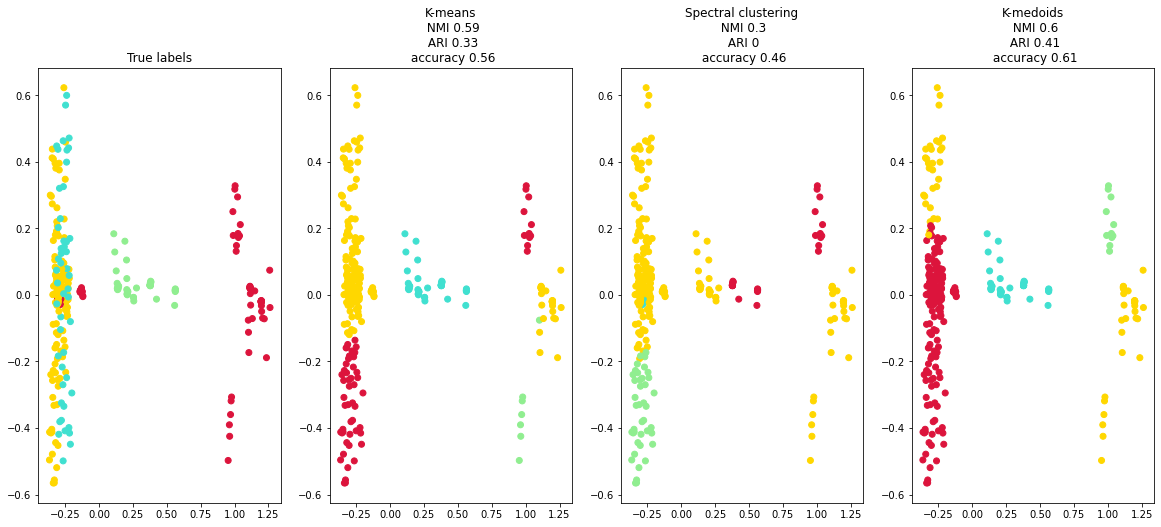

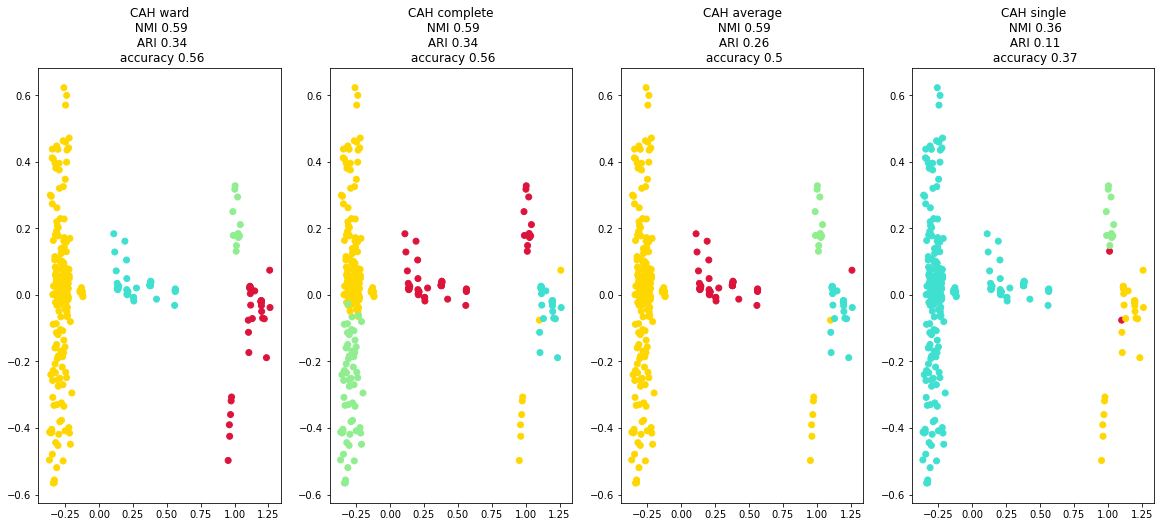

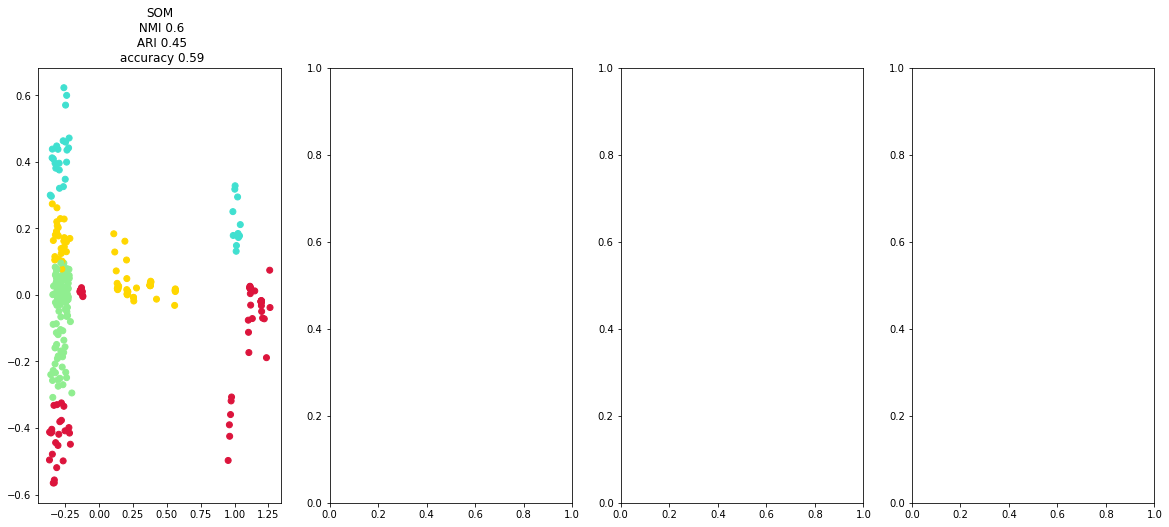

In [ ]:
eval_clustering_8(X_reduced, labels_int ,kmeans, spectral_clustering, kmedoids, cah_ward, cah_complete, cah_average,
                  cah_single, som, "True labels", "K-means", "Spectral clustering", "K-medoids", "CAH ward", "CAH complete",
                  "CAH average", "CAH single", "SOM")

## Discrete Fourier Transform

In [ ]:
from pyts.approximation import DiscreteFourierTransform

transformer = DiscreteFourierTransform(n_coefs=1)

In [ ]:
#transfomer le tableau de chaque variable individuellement
acce_x_transformed=transformer.fit_transform(df_acce_x_array)
acce_y_transformed=transformer.fit_transform(df_acce_y_array)
acce_z_transformed=transformer.fit_transform(df_acce_z_array)

accm_x_transformed=transformer.fit_transform(df_accm_x_array)
accm_y_transformed=transformer.fit_transform(df_accm_y_array)
accm_z_transformed=transformer.fit_transform(df_accm_z_array)

vit_x_transformed=transformer.fit_transform(df_vit_x_array)
vit_y_transformed=transformer.fit_transform(df_vit_y_array)
vit_z_transformed=transformer.fit_transform(df_vit_z_array)

In [ ]:
df_acce_x_transformed = pd.DataFrame(data=acce_x_transformed, index=np.array(range(1, 348)),
          columns=np.array(range(1, 2)))
df_acce_y_transformed = pd.DataFrame(data=acce_y_transformed, index=np.array(range(1, 348)),
          columns=np.array(range(1, 2)))
df_acce_z_transformed = pd.DataFrame(data=acce_z_transformed, index=np.array(range(1, 348)),
          columns=np.array(range(1, 2)))

df_accm_x_transformed = pd.DataFrame(data=accm_x_transformed, index=np.array(range(1, 348)),
          columns=np.array(range(1, 2)))
df_accm_y_transformed = pd.DataFrame(data=accm_y_transformed, index=np.array(range(1, 348)),
          columns=np.array(range(1, 2)))
df_accm_z_transformed = pd.DataFrame(data=accm_z_transformed, index=np.array(range(1, 348)),
          columns=np.array(range(1, 2)))

df_vit_x_transformed = pd.DataFrame(data=vit_x_transformed, index=np.array(range(1, 348)),
          columns=np.array(range(1, 2)))
df_vit_y_transformed = pd.DataFrame(data=vit_y_transformed, index=np.array(range(1, 348)),
          columns=np.array(range(1, 2)))
df_vit_z_transformed = pd.DataFrame(data=vit_z_transformed, index=np.array(range(1, 348)),
          columns=np.array(range(1, 2)))


In [ ]:
frames= [df_acce_x_transformed, df_acce_y_transformed, df_acce_z_transformed, df_accm_x_transformed, df_accm_y_transformed, df_accm_z_transformed,
         df_vit_x_transformed, df_vit_y_transformed, df_vit_z_transformed]

In [ ]:
#Concaténer dans un seul dataframe
df=pd.concat(frames, axis=1)

In [ ]:
df.shape

(347, 9)

### Kmeans

In [ ]:
kmeans_pred_labels=KMeans(k, random_state=42).fit(df).labels_
kmeans={"labels": kmeans_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmeans_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmeans_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmeans_pred_labels, labels_int),2)}

### Spectral clustering

In [ ]:
sepectral_pred_labels=SpectralClustering(k, affinity='nearest_neighbors', n_neighbors=5, random_state=42).fit(df).labels_

spectral_clustering= {"labels": sepectral_pred_labels,
                      "NMI": round(normalized_mutual_info_score(sepectral_pred_labels, labels_int),2),
                      "ARI": round(adjusted_rand_score(sepectral_pred_labels, labels_int)),
                      "accuracy": round(accuracy(sepectral_pred_labels, labels_int),2)}


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


### Kmedoids

In [ ]:
kmedoids_pred_labels = KMedoids(n_clusters=k,method='pam', random_state=42).fit(df).labels_
kmedoids={"labels": kmedoids_pred_labels,
        "NMI": round(normalized_mutual_info_score(kmedoids_pred_labels, labels_int),2),
        "ARI": round(adjusted_rand_score(kmedoids_pred_labels, labels_int),2),
        "accuracy": round(accuracy(kmedoids_pred_labels, labels_int),2)}

### CAH

In [ ]:
#CAH with ward aggregation criteria
cah_ward_pred_labels=AgglomerativeClustering(k, linkage = 'ward').fit(df).labels_

cah_ward= {"labels": cah_ward_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_ward_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_ward_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_ward_pred_labels, labels_int),2)}

In [ ]:
#CAH with complete aggregation criteria
cah_complete_pred_labels=AgglomerativeClustering(k, linkage = 'complete').fit(df).labels_

cah_complete= {"labels": cah_complete_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_complete_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_complete_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_complete_pred_labels, labels_int),2)}

In [ ]:
#CAH with average aggregation criteria
cah_average_pred_labels=AgglomerativeClustering(k, linkage = 'average').fit(df).labels_

cah_average= {"labels": cah_average_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_average_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_average_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_average_pred_labels, labels_int),2)}

In [ ]:
#CAH with single aggregation criteria
cah_single_pred_labels=AgglomerativeClustering(k, linkage = 'single').fit(df).labels_

cah_single= {"labels": cah_single_pred_labels,
          "NMI": round(normalized_mutual_info_score(cah_single_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(cah_single_pred_labels, labels_int),2),
          "accuracy": round(accuracy(cah_single_pred_labels, labels_int),2)}

### SOM

In [ ]:
som_pred_labels=fcps.SOMclustering(df.values, ClusterNo=k, alpha=0.5)[0]

som={"labels": som_pred_labels,
          "NMI": round(normalized_mutual_info_score(som_pred_labels, labels_int),2),
          "ARI": round(adjusted_rand_score(som_pred_labels, labels_int),2),
          "accuracy": round(accuracy(som_pred_labels, labels_int),2)}

In [ ]:
X_reduced=PCA(n_components=2, whiten=False, random_state=42).fit_transform(df)

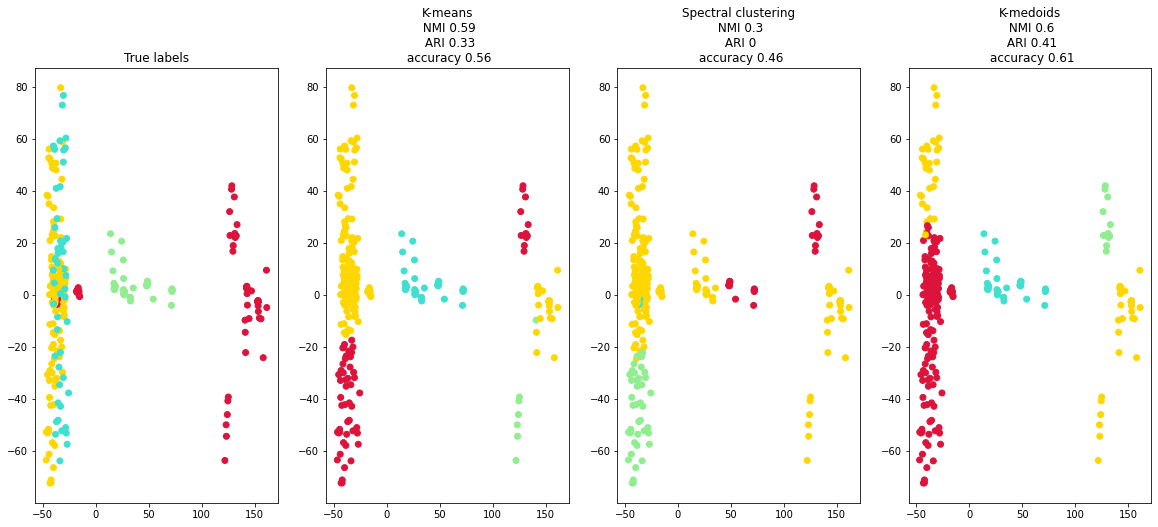

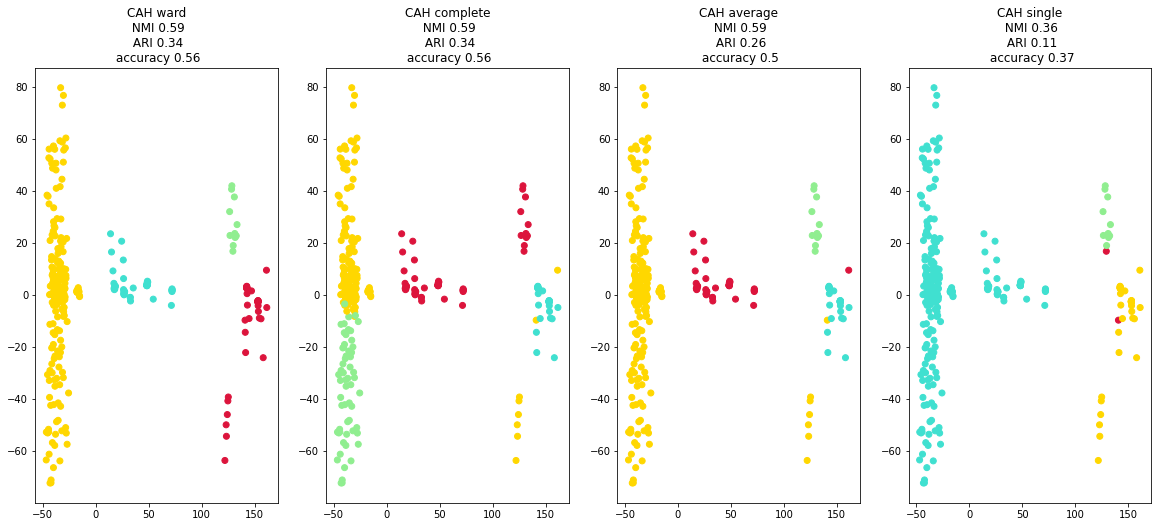

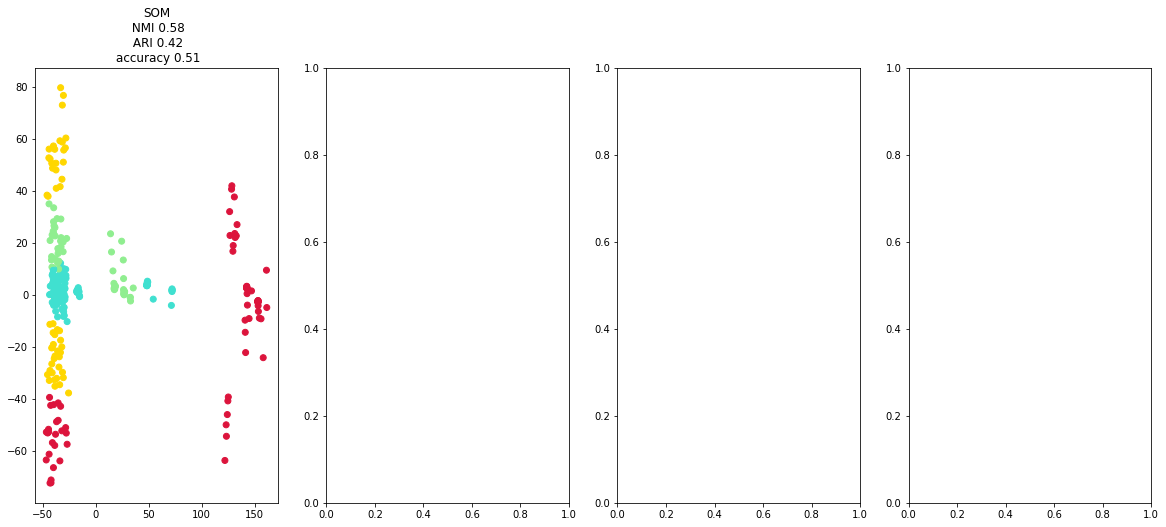

In [ ]:
eval_clustering_8(X_reduced, labels_int ,kmeans, spectral_clustering, kmedoids, cah_ward, cah_complete, cah_average,
                  cah_single, som, "True labels", "K-means", "Spectral clustering", "K-medoids", "CAH ward", "CAH complete",
                  "CAH average", "CAH single", "SOM")